<a href="https://colab.research.google.com/github/ConSeanway/RLforTwoDoseCOVIDVaccination/blob/main/Thesis_Project_Reinforcement_Learning_Application_to_COVID_19_Vaccine_Scheduling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reinforcement Learning:  Two-dose vaccine Game
Sean Conway
4-5-2021

In [ ]:
%tensorflow_version 1.x
!pip install stable-baselines[mpi]==2.10.0

TensorFlow 1.x selected.
     |████████████████████████████████| 256kB 6.6MB/s 
  Found existing installation: stable-baselines 2.2.1
    Uninstalling stable-baselines-2.2.1:
      Successfully uninstalled stable-baselines-2.2.1


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib
from math import exp
from math import sqrt
from math import log
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import gym
from gym import spaces
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.policies import MlpPolicy
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import TRPO
from stable_baselines import results_plotter
import statistics
import random
from stable_baselines.common import make_vec_env
from stable_baselines import A2C
from stable_baselines import SAC
from stable_baselines.common import vec_env as vecEnv
import seaborn as sns
import pandas as pd
import pickle
import scipy.stats as st
import seaborn as sns
import pandas as pd

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



### Parameters

In [ ]:
n_periods = 200

supplyMean = 17000

gamma = 0.995

h = 1
p = 30

capacity = 1.5*supplyMean/7

# Capacity should be flexible.  It's ok to go over a little bit and just say that we need the extra space
# In terms of constraints, SD without first dose is most important, then SD not given penalty, then overschedule penalty
overschedulePenalty = 100
SDWithoutFirstDosePenalty = 300
SDNotGivenPenalty = 150

SDSocialBenefit = 10

# Pulled from Medicare website
# https://www.cms.gov/medicare/covid-19/medicare-covid-19-vaccine-shot-payment
FDRevenueFactor = 16.94
SDRevenueFactor = 28.39 + SDSocialBenefit

daysBeforeSD = 21
# Should be additional number of days you want SD patient to be able to be vaccinated w/o "not given" penalty
# e.g. if you want 7 days to give SD, this number should be 6
gracePeriodLength = 13

# FD decision delay, we assume SD patients are instantly served
decisionDelay = 2

# Arrivals for supply parameters
meanDaysBetweenArrivals = 7
pctChanceForDelay = 0.15

# Probability of no-show (FD or SD?)
# 5% chance of patient not showing up for FD
FDNoShowProb = 0.05

### Custom Gym Environment for the Game

In [ ]:
class TwoDoseVaccineEnv(gym.Env):
  
  def __init__(self, discRate=gamma, maxPeriods=n_periods, meanDaysBetweenArrivals=meanDaysBetweenArrivals):
    super(TwoDoseVaccineEnv, self).__init__()

    # Action space = [number of FD vaccines to give this period, number of SD vaccines to give this period]
    self.action_space = spaces.Box(low=np.array([0, 0]).astype(np.float32), high=np.array([1, 1]).astype(np.float32), shape=(2,), dtype=np.float32)
    
    # Observation space = [period, inventory, FD Stockouts, SD Stockouts, SD due in n periods, SD due in n-1 periods, ... , SD due next period]
    #self.observation_space = spaces.Box(low=np.array([0, 0, 0]).astype(np.float32), high=np.array([10, 1000, 200]).astype(np.float32), shape=(3,), dtype=np.float32)
    self.observation_space = spaces.Box(low=np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).astype(np.float32), high=np.array([n_periods, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean, supplyMean]).astype(np.float32), shape=(16,), dtype=np.float32)

    self.discRate = discRate
    self.startingInv = 0
    self.time = 0
    self.maxPeriods = maxPeriods
    self.hadArrivalThisWeek = False
    # Grace period is the list that keeps track of the number of SD patients that are still OK to use
    self.SDPatientsInGracePeriod = [0] * gracePeriodLength

    # Organized:  index 0 means that they're due today.  Index len(daysBeforeSD) - 1 will contain all FD patients we serve today
    self.patientsDueForSD = [0] * daysBeforeSD
    self.nextArrivalTime = 0
    self.FDDecisionQueue = [0] * decisionDelay
    self.meanDaysBetweenArrivals = meanDaysBetweenArrivals
    self.reset()

  def step(self, action):

    # Reset whether you've had an arrival or not
    if self.time % self.meanDaysBetweenArrivals == 0:
      self.hadArrivalThisWeek = False
      # Period 1 you should get an arrival
      self.nextArrivalTime = self.time
      # Late arrival case
      if np.random.random() < pctChanceForDelay:
        self.nextArrivalTime += 1

    # Take user action as the percent of capacity number of first dose and second dose vaccines to give

    #FDVaccinesToGive = capacity * (action[0])
    #SDVaccinesToGive = capacity * (action[1])

    FDVaccinesToGive = self.FDDecisionQueue[0] * (1-FDNoShowProb)
    SDVaccinesToGive = capacity * action[1]

    # Cycle through the FD decision queue (index 0 means it's due next period...  Decision you make now is going to be in 2 periods)
    newDecisionQueue = self.FDDecisionQueue[1:]
    newDecisionQueue.append(capacity * action[0])
    self.FDDecisionQueue = newDecisionQueue

    # Pull inventory from the previous state[1] (old state's inventory), and pull the number of second dose patients due today from it too
    oldInventory = self.state[1]
    newPatientsAvailableForSD = self.state[9]
    totalSDPatientsAvailableToday = sum(self.state[9:])
    lastDaySDPatients = self.state[len(self.state) - 1]

    # Incur second dose-related costs
    # Cannot give more second doses than you have people able to get the second dose (Decision-based cost)
    SDViolationCost = SDWithoutFirstDosePenalty * max(SDVaccinesToGive - totalSDPatientsAvailableToday, 0)

    # Penalize if you go over capacity (renting cost)
    capacityPenalty = overschedulePenalty * max(FDVaccinesToGive + SDVaccinesToGive - capacity, 0)

    # Get the supply
    randomSupply = 0
    if self.time == self.nextArrivalTime:
      randomSupply = supplyMean
      self.hadArrivalThisWeek = True

    FDPatientsArrived = FDVaccinesToGive * (1-FDNoShowProb)
    SDPatientsArrived = SDVaccinesToGive

    # Get the supply, serve patients with available vaccine, then calculate new inventory position
    inventory = max(oldInventory + randomSupply - FDPatientsArrived - SDPatientsArrived, 0)

    # Stockouts can be calculated from the old inventory, supply, FDVaccines given, and SD vaccines given
    stockouts = max(FDPatientsArrived + SDPatientsArrived - randomSupply - oldInventory, 0)

    # Assume FIFO (second dose gets served before FD).
    SDStockouts = max(SDPatientsArrived - randomSupply - oldInventory, 0)
    FDStockouts = max(stockouts - SDStockouts, 0)

    # Right now, holding and stockout costs are the same for FD and SD
    holdingCostIncurred = h * inventory
    stockoutCostIncurred = p * stockouts

    # Calculate the number of customers served for each dose, the revenue from each, and then determine the reward
    FDCustomersServed = FDPatientsArrived - FDStockouts
    SDCustomersServed = SDPatientsArrived - SDStockouts

    FDRevenue = FDRevenueFactor * FDCustomersServed
    SDRevenue = SDRevenueFactor * SDCustomersServed

    SDVaccineNotGivenCost = SDNotGivenPenalty * max(lastDaySDPatients - SDCustomersServed, 0)
    
    totalRevenue = FDRevenue + SDRevenue
    totalCost = holdingCostIncurred + stockoutCostIncurred + SDViolationCost + SDVaccineNotGivenCost + capacityPenalty

    # reward = (totalRevenue - totalCost) * (self.discRate ** self.time)   ## for discounting, use left
    reward = (totalRevenue - totalCost) * (self.discRate ** self.time)
    #reward = totalRevenue - totalCost

    # Perform the time shift...  Patients that were given their first dose are scheduled for their second dose.  Once they hit index 0, they'll be brought back
    SDEligible = self.patientsDueForSD[1:]
    SDEligible.append(FDCustomersServed)
    self.patientsDueForSD = SDEligible

    # Account for the number of customers that got served
    leftToServe = SDCustomersServed
    for gracePeriod in range(len(self.SDPatientsInGracePeriod)):
      if self.SDPatientsInGracePeriod[gracePeriod] > 0:
        if leftToServe - self.SDPatientsInGracePeriod[gracePeriod] > 0:
          leftToServe -= self.SDPatientsInGracePeriod[gracePeriod]
          self.SDPatientsInGracePeriod[gracePeriod] = 0
        elif leftToServe > 0:
          self.SDPatientsInGracePeriod[gracePeriod] -= leftToServe
          leftToServe = 0
      self.SDPatientsInGracePeriod[gracePeriod] = max(self.SDPatientsInGracePeriod[gracePeriod], 0)

    # Perform grace period time shift
    timeShiftedSDGracePeriod = self.SDPatientsInGracePeriod[1:]
    # Have to serve today's patients last
    timeShiftedSDGracePeriod.append(max(newPatientsAvailableForSD - leftToServe, 0))
    self.SDPatientsInGracePeriod = timeShiftedSDGracePeriod

    # Move time forward, record state
    self.time += 1

    newState = [self.time, inventory, FDVaccinesToGive, FDPatientsArrived, SDPatientsArrived, FDStockouts, SDStockouts, self.FDDecisionQueue[0], self.FDDecisionQueue[1], SDEligible[0], self.SDPatientsInGracePeriod[5], self.SDPatientsInGracePeriod[4], self.SDPatientsInGracePeriod[3], self.SDPatientsInGracePeriod[2], self.SDPatientsInGracePeriod[1], self.SDPatientsInGracePeriod[0]]

    # State:  time, inventory, number of FD stockouts, number of SD stockouts, number of SD to schedule tomorrow
    self.state = np.array(newState).astype(np.float32)

    return self.state, reward, self.time > self.maxPeriods, {}

  def reset(self):
    self.state = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]).astype(np.float32)
    self.patientsDueForSD = [0] * daysBeforeSD
    self.SDPatientsInGracePeriod = [0] * gracePeriodLength
    self.FDDecisionQueue = [0] * decisionDelay
    self.time = 0
    self.nextArrivalTime = 0
    self.hadArrivalThisWeek = False
    return self.state

env = TwoDoseVaccineEnv()
check_env(env)

/usr/local/lib/python3.7/dist-packages/stable_baselines/common/env_checker.py:210: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf https://stable-baselines.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn("We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) "


### Basic Policies

#### Policy:  Consistent Scheduling

Common sense policy will be to schedule 1/2 of your capacity in period 1 to period n for first doses
Other 0.95 * 1/2 of the capacity will be reserved for 2nd doses

In [ ]:
game = TwoDoseVaccineEnv()
obs = game.reset()

FDPatients = 0.5
SDPatients = 0.5 * (1-(FDNoShowProb * 1.5))

Run the basic simulation

In [ ]:
printouts = False
printThresh = 200
num_simulations = 1000

FDPatients = 0.45
SDPatients = 0.4

compareRunTotalRewards = []
compareRunFDQtys = []
compareRunSDQtys = []
compareRunInventories = []
compareRunPeriodRewards = []
compareRunFDStockouts = []
compareRunSDStockouts = []
compareRunNeverServedSDPatients = []

for trial in range(num_simulations):
  game.reset()
  totReward = 0
  done = False
  i = 1

  compareFDQtys = []
  compareSDQtys = []
  compareInventories = []
  comparePeriodRewards = []
  compareFDStockouts = []
  compareSDStockouts = []
  compareSDPatientsNeverServed = []

  obs = game.state
  if printouts:
    print("Starting State")
    print("Observation Space")
    print("Time", obs[0])
    print("Inventory", obs[1])
    print("FD Vaccines Given (planned) this period", obs[2])
    print("FD Patients Arriving this period", obs[3])
    print("SD Vaccines Given (planned) this period", obs[4])
    print("Number of FD Stockouts", obs[5])
    print("Number of SD Stockouts", obs[6])
    print("Number of FD Orders next period", obs[7])
    print("Number of FD Orders 2 periods from now", obs[8])
    print("Number of newly eligible SD patients", obs[9])
    print("SD patients with 6 days left", obs[10])
    print("SD patients with 5 days left", obs[11])
    print("SD patients with 4 days left", obs[12])
    print("SD patients with 3 days left", obs[13])
    print("SD patients with 2 days left", obs[14])
    print("SD patients with 1 day left", obs[15])
    print()

  SDPatientsThatNeedVaxThisPd = obs[15]

  while not done:

    #prediction = model.predict(obs, deterministic=True)
    action = []

    if i > daysBeforeSD + 5 + 7:
      action = [FDPatients, SDPatients]
    else:
      action = [FDPatients, 0]

    compareFDQtys.append(action[0] * capacity)
    compareSDQtys.append(action[1] * capacity)

    obs, rewards, done, info = game.step(action)
    #print("Observation", obs)

    if obs[0] <= printThresh and printouts:
      print()
      print("Period", i)
      print("Action")
      print("FD Qty", action[0] * capacity)
      print("SD Qty", action[1] * capacity)
      print()
      print("Observation Space")
      print("Time", obs[0])
      print("Inventory", obs[1])
      print("FD Vaccines Given (planned) this period", obs[2])
      print("FD Patients Arriving this period", obs[3])
      print("SD Vaccines Given (planned) this period", obs[4])
      print("Number of FD Stockouts", obs[5])
      print("Number of SD Stockouts", obs[6])
      print("Number of FD Orders next period", obs[7])
      print("Number of FD Orders 2 periods from now", obs[8])
      print("Number of newly eligible SD patients", obs[9])
      print("SD patients with 6 days left", obs[10])
      print("SD patients with 5 days left", obs[11])
      print("SD patients with 4 days left", obs[12])
      print("SD patients with 3 days left", obs[13])
      print("SD patients with 2 days left", obs[14])
      print("SD patients with 1 day left", obs[15])

      print("Rewards", round(rewards, 2))
      print()
    comparePeriodRewards.append(rewards)
    compareInventories.append(obs[1])
    compareFDStockouts.append(obs[5])
    compareSDStockouts.append(obs[6])

    # Calculate the number of patients that went unserved:
    SDPatientsPlanned = action[1] * capacity
    SDStockoutsThisPd = obs[6]
    SDServedThisPd = SDPatientsPlanned - SDStockoutsThisPd

    if SDServedThisPd >= SDPatientsThatNeedVaxThisPd:
      SDPatientsThatNeverGotSD = 0
    else:
      SDPatientsThatNeverGotSD = max(SDPatientsThatNeedVaxThisPd - SDServedThisPd, 0)

    compareSDPatientsNeverServed.append(SDPatientsThatNeverGotSD)

    SDPatientsThatNeedVaxThisPd = obs[15]

    totReward += rewards
    i += 1

  if printouts:
    print()
  print("Total Reward=", totReward)
  compareRunTotalRewards.append(totReward)
  compareRunFDQtys.append(compareFDQtys)
  compareRunSDQtys.append(compareSDQtys)
  compareRunInventories.append(compareInventories)
  compareRunPeriodRewards.append(comparePeriodRewards)
  compareRunFDStockouts.append(compareFDStockouts)
  compareRunSDStockouts.append(compareSDStockouts)
  compareRunNeverServedSDPatients.append(compareSDPatientsNeverServed)

Total Reward= 4458761.125292403
Total Reward= 4447603.091005196
Total Reward= 4461742.968242235
Total Reward= 4583515.237336182
Total Reward= 4332646.797796375
Total Reward= 4606898.9664941635
Total Reward= 4599016.586745735
Total Reward= 4630666.805497151
Total Reward= 4501556.820027539
Total Reward= 4469161.864333575
Total Reward= 4619078.597400282
Total Reward= 4647485.760196496
Total Reward= 4491356.556029984
Total Reward= 4603544.197820578
Total Reward= 4600433.067174136
Total Reward= 4492568.591892707
Total Reward= 4503067.984876386
Total Reward= 4602257.184070816
Total Reward= 4613263.847962799
Total Reward= 4592846.3140043095
Total Reward= 4623519.834775096
Total Reward= 4488761.36478616
Total Reward= 4590587.332211599
Total Reward= 4516812.121730206
Total Reward= 4598171.420048673
Total Reward= 4583697.855312654
Total Reward= 4693671.689317092
Total Reward= 4295369.609894248
Total Reward= 4581190.937056948
Total Reward= 4607405.400507491
Total Reward= 4581723.057955338
Total R

Get histogram

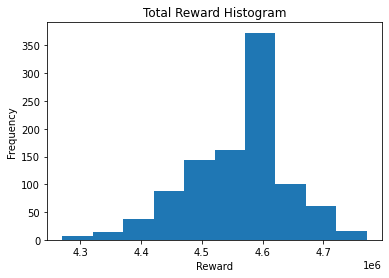

In [ ]:
# Just out of curiosity I want to see this histogram:
plt.hist(compareRunTotalRewards)
plt.title("Total Reward Histogram")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print("Mean=", np.mean(compareRunTotalRewards))
print(st.t.interval(alpha=0.95, df=len(compareRunTotalRewards) - 1, loc=np.mean(compareRunTotalRewards), scale=st.sem(compareRunTotalRewards)))

Mean= 4561491.741949762
(4556451.892316273, 4566531.591583251)


In [ ]:
4561491.74 - 4556451.89

5039.850000000559

In [ ]:
sqrt(st.describe(compareRunTotalRewards).variance)

81216.26242042963

Aggregate Data

In [ ]:
# Now we need to aggregate the data we just collected...  use a simple average for now (can also get st deviations and whatnot)

# Basically, I'm going to want to iterate through the simulation's data.

simulationPeriods = len(compareRunFDQtys[0])
numberSimulations = len(compareRunTotalRewards)
numberColumns = 7

# = [[0] * numberSimulations] * simulationPeriods

compareData = []

# For each period in the simulation...
for simPeriod in range(simulationPeriods):

  FDQtyDecision = []
  SDQtyDecision = []

  inventoryThisPd = []
  rewardThisPd = []
  FDStockoutsThisPd = []
  SDStockoutsThisPd = []
  SDPatientsNeverServedThisPd = []

  # For each simulation...
  for simRunNo in range(numberSimulations):
  
    FDQtyDecision.append(compareRunFDQtys[simRunNo][simPeriod])
    SDQtyDecision.append(compareRunSDQtys[simRunNo][simPeriod])
    inventoryThisPd.append(compareRunInventories[simRunNo][simPeriod])
    rewardThisPd.append(compareRunPeriodRewards[simRunNo][simPeriod])
    FDStockoutsThisPd.append(compareRunFDStockouts[simRunNo][simPeriod])
    SDStockoutsThisPd.append(compareRunSDStockouts[simRunNo][simPeriod])
    SDPatientsNeverServedThisPd.append(compareRunSDStockouts[simRunNo][simPeriod])

  avgFDQty = sum(FDQtyDecision)/len(FDQtyDecision)
  avgSDQty = sum(SDQtyDecision)/len(SDQtyDecision)
  avgInv = sum(inventoryThisPd)/len(inventoryThisPd)
  avgRew = sum(rewardThisPd)/len(rewardThisPd)
  avgFDStockout = sum(FDStockoutsThisPd)/len(FDStockoutsThisPd)
  avgSDStockout = sum(SDStockoutsThisPd)/len(SDStockoutsThisPd)
  avgSDPatientNeverServed = sum(SDPatientsNeverServedThisPd)/len(SDPatientsNeverServedThisPd)
  compareData.append({"period": simPeriod, "FDQty": avgFDQty, "SDQty": avgSDQty, "inventory": avgInv, "reward": avgRew, "FDStockoutQty": avgFDStockout ,"SDStockoutQty": avgSDStockout, "SDPatientsNeverServed": avgSDPatientNeverServed})



avgReward = sum(compareRunTotalRewards) / len(compareRunTotalRewards)
print(avgReward)# Now we need to aggregate the data we just collected...  use a simple average for now (can also get st deviations and whatnot)

4561491.741949758


In [ ]:
# Convert to using the older variables (skip if you're just looking at one simulation)

compareFDQtys = [i["FDQty"] for i in compareData]
compareSDQtys = [i["SDQty"] for i in compareData]
comparePeriodRewards = [i["reward"] for i in compareData]
compareInventories = [i["inventory"] for i in compareData]
compareFDStockouts = [i["FDStockoutQty"] for i in compareData]
compareSDStockouts = [i["SDStockoutQty"] for i in compareData]
compareSDPatientsNeverServed = [i["SDPatientsNeverServed"] for i in compareData]

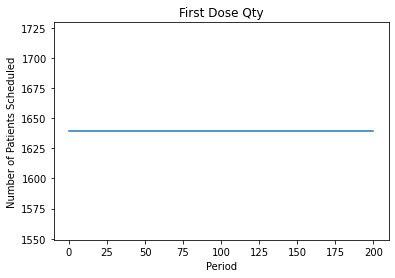

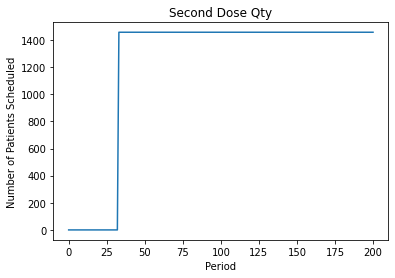

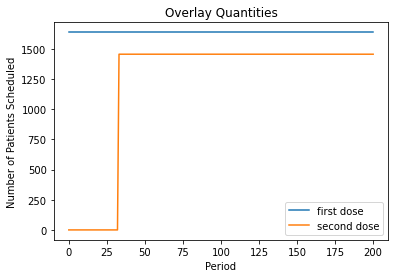

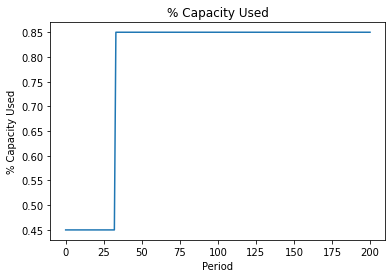

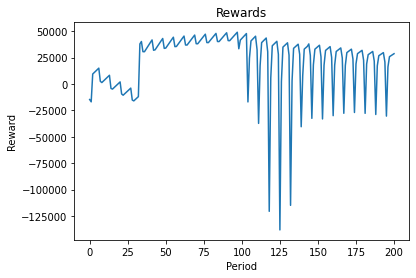

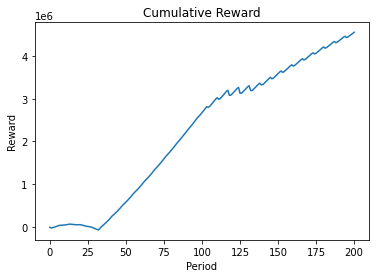

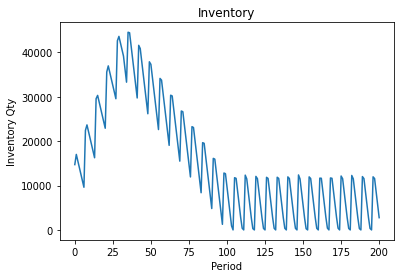

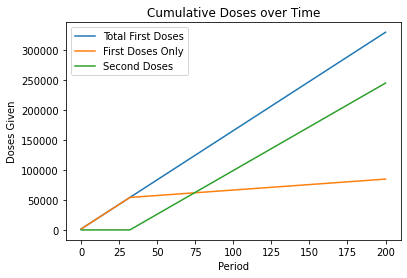

Total First Doses Given (Average): 300405.85425477265
Total Second Doses Given (Average): 224921.46649158024



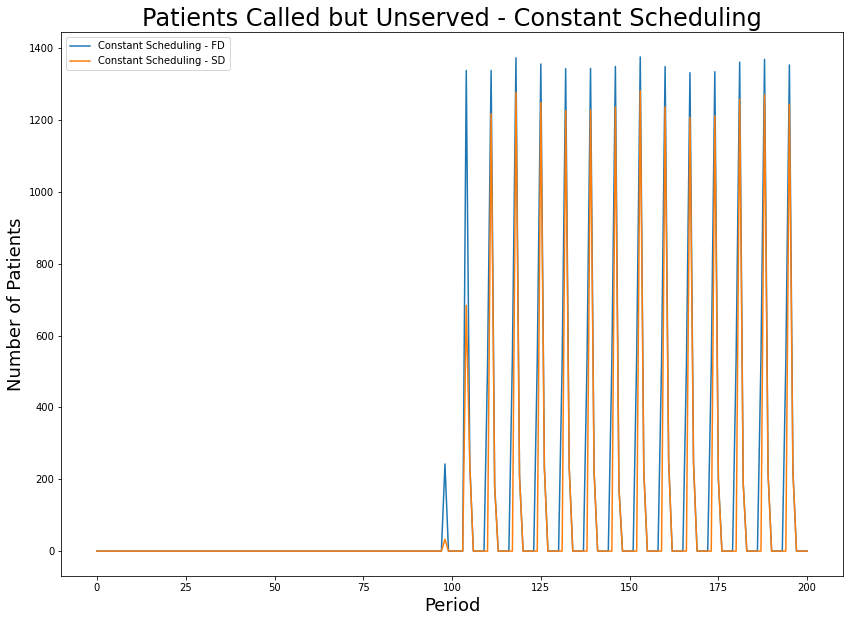

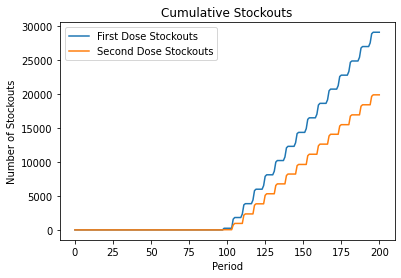

Cumulative SD Patients Never Served: 19878.533508422854
Percentage of total SD Patients: 0.088379885737438


In [ ]:
# Below plots are for a single run...

# First Dose
plt.plot(compareFDQtys)
plt.title("First Dose Qty")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.show()

# Second Dose
plt.plot(compareSDQtys)
plt.title("Second Dose Qty")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.show()

# Overlay
plt.plot(compareFDQtys, label="first dose")
plt.plot(compareSDQtys, label="second dose")
plt.title("Overlay Quantities")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.legend()
plt.show()

# Capacity Check
plt.plot(np.add(compareFDQtys, compareSDQtys)/capacity)
plt.title("% Capacity Used")
plt.xlabel("Period")
plt.ylabel("% Capacity Used")
plt.show()

# Reward
plt.plot(comparePeriodRewards)
plt.title("Rewards")
plt.xlabel("Period")
plt.ylabel("Reward")
plt.show()

# cumulative sum
def Cumulative(l):
   new = []
   cumsum = 0
   for element in l:
      cumsum += element
      new.append(cumsum)
   return new

# Cumulative Reward
plt.plot(Cumulative(comparePeriodRewards))
plt.title("Cumulative Reward")
plt.xlabel("Period")
plt.ylabel("Reward")
plt.show()

# Inventory
plt.plot(compareInventories)
plt.title("Inventory")
plt.xlabel("Period")
plt.ylabel("Inventory Qty")
plt.show()

# Cumulative FDs and SDs
plt.plot(Cumulative(compareFDQtys), label="Total First Doses")
plt.plot(np.subtract(Cumulative(compareFDQtys), Cumulative(compareSDQtys)), label="First Doses Only")
plt.plot(Cumulative(compareSDQtys), label="Second Doses")
#plt.plot(Cumulative(FDQtys)) - Cumulative(SDQtys))
plt.title("Cumulative Doses over Time")
plt.xlabel("Period")
plt.ylabel("Doses Given")
plt.legend()
plt.show()

compareAvgFDServed = Cumulative(compareFDQtys)[len(compareFDQtys) - 1] - Cumulative(compareFDStockouts)[len(compareFDStockouts) - 1]
compareAvgSDServed = Cumulative(compareSDQtys)[len(compareSDQtys) - 1] - Cumulative(compareSDStockouts)[len(compareSDStockouts) - 1]

print("Total First Doses Given (Average):", compareAvgFDServed)
print("Total Second Doses Given (Average):", compareAvgSDServed)
print()

# Stockouts
plt.figure(figsize=(14, 10))
plt.plot(compareFDStockouts, label="Constant Scheduling - FD")
plt.plot(compareSDStockouts, label="Constant Scheduling - SD")
plt.title("Patients Called but Unserved - Constant Scheduling", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients", fontsize=18)
plt.legend()
plt.show()

# Cumulative Stockouts
plt.plot(Cumulative(compareFDStockouts), label="First Dose Stockouts")
plt.plot(Cumulative(compareSDStockouts), label="Second Dose Stockouts")
plt.title("Cumulative Stockouts")
plt.xlabel("Period")
plt.ylabel("Number of Stockouts")
plt.legend()
plt.show()

print("Cumulative SD Patients Never Served:", Cumulative(compareSDPatientsNeverServed)[len(compareSDPatientsNeverServed) - 1])
print("Percentage of total SD Patients:", Cumulative(compareSDPatientsNeverServed)[len(compareSDPatientsNeverServed) - 1] / compareAvgSDServed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


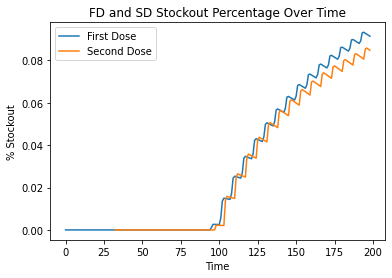

In [ ]:
compareFDTimeAdjusted = compareFDQtys[2:]
compareSDTimeAdjusted = compareSDQtys[:-2]
compareFDStockoutsTimeAdjusted = compareFDStockouts[2:]
compareSDStockoutsTimeAdjusted = compareSDStockouts[:-2]

plt.plot(np.divide(Cumulative(compareFDStockoutsTimeAdjusted), Cumulative(compareFDTimeAdjusted)), label="First Dose")
plt.plot(np.divide(Cumulative(compareSDStockoutsTimeAdjusted), Cumulative(compareSDTimeAdjusted)), label="Second Dose")
plt.title("FD and SD Stockout Percentage Over Time")
plt.xlabel("Time")
plt.ylabel("% Stockout")
plt.legend()
plt.show()

##### Optimization for Constant Scheduling Policy

In [ ]:
printouts = False
printThresh = 200
num_simulations = 500

optimizationFDQtys = []
optimizationSDQtys = []
optimizationRewards = []

game = TwoDoseVaccineEnv()

#FDPatients = 0.5
#SDPatients = 0.5 * (1-(FDNoShowProb * 1.5))

for thisFDQty in range(42 - 4, 42 + 5, 1):
  for thisSDQty in range(40 - 4, 40 + 5, 1):

    print("FDQty=", thisFDQty, " SDQty=", thisSDQty)

    FDPatients = thisFDQty / 100
    SDPatients = thisSDQty / 100

    compareRunTotalRewards = []

    for trial in range(num_simulations):
      game.reset()
      totReward = 0
      done = False
      i = 1


      obs = game.state
      if printouts:
        print("Starting State")
        print("Observation Space")
        print("Time", obs[0])
        print("Inventory", obs[1])
        print("FD Vaccines Given (planned) this period", obs[2])
        print("FD Patients Arriving this period", obs[3])
        print("SD Vaccines Given (planned) this period", obs[4])
        print("Number of FD Stockouts", obs[5])
        print("Number of SD Stockouts", obs[6])
        print("Number of FD Orders next period", obs[7])
        print("Number of FD Orders 2 periods from now", obs[8])
        print("Number of newly eligible SD patients", obs[9])
        print("SD patients with 6 days left", obs[10])
        print("SD patients with 5 days left", obs[11])
        print("SD patients with 4 days left", obs[12])
        print("SD patients with 3 days left", obs[13])
        print("SD patients with 2 days left", obs[14])
        print("SD patients with 1 day left", obs[15])
        print()

      while not done:

        #prediction = model.predict(obs, deterministic=True)
        action = []

        if i > daysBeforeSD + 2 + 2:
          action = [FDPatients, SDPatients]
        else:
          action = [FDPatients, 0]

        compareFDQtys.append(action[0] * capacity)
        compareSDQtys.append(action[1] * capacity)

        obs, rewards, done, info = game.step(action)
        #print("Observation", obs)

        if obs[0] <= printThresh and printouts:
          print()
          print("Period", i)
          print("Action")
          print("FD Qty", action[0] * capacity)
          print("SD Qty", action[1] * capacity)
          print()
          print("Observation Space")
          print("Time", obs[0])
          print("Inventory", obs[1])
          print("FD Vaccines Given (planned) this period", obs[2])
          print("FD Patients Arriving this period", obs[3])
          print("SD Vaccines Given (planned) this period", obs[4])
          print("Number of FD Stockouts", obs[5])
          print("Number of SD Stockouts", obs[6])
          print("Number of FD Orders next period", obs[7])
          print("Number of FD Orders 2 periods from now", obs[8])
          print("Number of newly eligible SD patients", obs[9])
          print("SD patients with 6 days left", obs[10])
          print("SD patients with 5 days left", obs[11])
          print("SD patients with 4 days left", obs[12])
          print("SD patients with 3 days left", obs[13])
          print("SD patients with 2 days left", obs[14])
          print("SD patients with 1 day left", obs[15])

          print("Rewards", round(rewards, 2))
          print()
        totReward += rewards
        i += 1

      if printouts:
        print()
      #print("Total Reward=", totReward)
      compareRunTotalRewards.append(totReward)

    avgReward = sum(compareRunTotalRewards) / len(compareRunTotalRewards)
    #print(avgReward)# Now we need to aggregate the data we just collected...  use a simple average for now (can also get st deviations and whatnot)

    optimizationFDQtys.append(thisFDQty)
    optimizationSDQtys.append(thisSDQty)
    optimizationRewards.append(avgReward)


FDQty= 38  SDQty= 36
FDQty= 38  SDQty= 37
FDQty= 38  SDQty= 38
FDQty= 38  SDQty= 39
FDQty= 38  SDQty= 40
FDQty= 38  SDQty= 41
FDQty= 38  SDQty= 42
FDQty= 38  SDQty= 43
FDQty= 38  SDQty= 44
FDQty= 39  SDQty= 36
FDQty= 39  SDQty= 37
FDQty= 39  SDQty= 38
FDQty= 39  SDQty= 39
FDQty= 39  SDQty= 40
FDQty= 39  SDQty= 41
FDQty= 39  SDQty= 42
FDQty= 39  SDQty= 43
FDQty= 39  SDQty= 44
FDQty= 40  SDQty= 36
FDQty= 40  SDQty= 37
FDQty= 40  SDQty= 38
FDQty= 40  SDQty= 39
FDQty= 40  SDQty= 40
FDQty= 40  SDQty= 41
FDQty= 40  SDQty= 42
FDQty= 40  SDQty= 43
FDQty= 40  SDQty= 44
FDQty= 41  SDQty= 36
FDQty= 41  SDQty= 37
FDQty= 41  SDQty= 38
FDQty= 41  SDQty= 39
FDQty= 41  SDQty= 40
FDQty= 41  SDQty= 41
FDQty= 41  SDQty= 42
FDQty= 41  SDQty= 43
FDQty= 41  SDQty= 44
FDQty= 42  SDQty= 36
FDQty= 42  SDQty= 37
FDQty= 42  SDQty= 38
FDQty= 42  SDQty= 39
FDQty= 42  SDQty= 40
FDQty= 42  SDQty= 41
FDQty= 42  SDQty= 42
FDQty= 42  SDQty= 43
FDQty= 42  SDQty= 44
FDQty= 43  SDQty= 36
FDQty= 43  SDQty= 37
FDQty= 43  SD

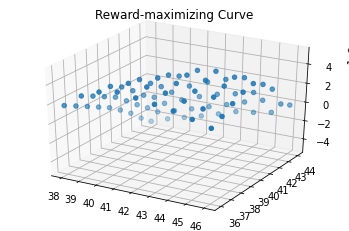

In [ ]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting code
ax.scatter(optimizationFDQtys, optimizationSDQtys, optimizationRewards, 'blue')
ax.set_title('Reward-maximizing Curve')
plt.show()

In [ ]:
# find maximum value
print("Maximum reward", max(optimizationRewards))
print("At Index", optimizationRewards.index(max(optimizationRewards)))
bestIdx = optimizationRewards.index(max(optimizationRewards))
print("FDQty", optimizationFDQtys[bestIdx])
print("SDQty", optimizationSDQtys[bestIdx])

Maximum reward 4986409.08974373
At Index 58
FDQty 44
SDQty 40


Pfizer:
- Maximum reward 5066383.86
- FDQty 45
- SDQty 40

Moderna:
- Maximum Reward = 5065440.16
- FDQty = 45
- SDQty = 40


#### Policy: Bang-Bang

Alternate between first dose and second dose scheduling.  FD should be run for 33 periods, then SD should be run for 33 periods

In [ ]:
printouts = False
printThresh = 0
num_simulations = 1000

# Period of 66 seems to work best for this simulation
periodLength = 67

#FDPatients = 1 / 1.3
#SDPatients = (1 - 2 * FDNoShowProb) / 1.3

FDPatients = 0.74
SDPatients = 0.67

bangbangRunTotalRewards = []
bangbangRunFDQtys = []
bangbangRunSDQtys = []
bangbangRunInventories = []
bangbangRunPeriodRewards = []
bangbangRunFDStockouts = []
bangbangRunSDStockouts = []
bangbangRunNeverServedSDPatients = []

for trial in range(num_simulations):
  game.reset()
  totReward = 0
  done = False
  i = 1

  bangbangFDQtys = []
  bangbangSDQtys = []
  bangbangInventories = []
  bangbangPeriodRewards = []
  bangbangFDStockouts = []
  bangbangSDStockouts = []
  bangbangSDPatientsNeverServed = []

  obs = game.state
  if printouts:
    print("Starting State")
    print("Observation Space")
    print("Time", obs[0])
    print("Inventory", obs[1])
    print("FD Vaccines Given (planned) this period", obs[2])
    print("FD Patients Arriving this period", obs[3])
    print("SD Vaccines Given (planned) this period", obs[4])
    print("Number of FD Stockouts", obs[5])
    print("Number of SD Stockouts", obs[6])
    print("Number of FD Orders next period", obs[7])
    print("Number of FD Orders 2 periods from now", obs[8])
    print("Number of newly eligible SD patients", obs[9])
    print("SD patients with 6 days left", obs[10])
    print("SD patients with 5 days left", obs[11])
    print("SD patients with 4 days left", obs[12])
    print("SD patients with 3 days left", obs[13])
    print("SD patients with 2 days left", obs[14])
    print("SD patients with 1 day left", obs[15])
    print()

  SDPatientsThatNeedVaxThisPd = obs[15]

  while not done:

    #prediction = model.predict(obs, deterministic=True)
    action = []

    # Policy idea:  Assuming period = 66
    if (i % periodLength) < (periodLength / 2):
      action = [FDPatients, 0]
    else:
      action = [0, SDPatients]

    bangbangFDQtys.append(action[0] * capacity)
    bangbangSDQtys.append(action[1] * capacity)

    obs, rewards, done, info = game.step(action)
    #print("Observation", obs)

    if obs[0] <= printThresh and printouts:
      print()
      print("Period", i)
      print("Action")
      print("FD Qty", action[0] * capacity)
      print("SD Qty", action[1] * capacity)
      print()
      print("Observation Space")
      print("Time", obs[0])
      print("Inventory", obs[1])
      print("FD Vaccines Given (planned) this period", obs[2])
      print("FD Patients Arriving this period", obs[3])
      print("SD Vaccines Given (planned) this period", obs[4])
      print("Number of FD Stockouts", obs[5])
      print("Number of SD Stockouts", obs[6])
      print("Number of FD Orders next period", obs[7])
      print("Number of FD Orders 2 periods from now", obs[8])
      print("Number of newly eligible SD patients", obs[9])
      print("SD patients with 6 days left", obs[10])
      print("SD patients with 5 days left", obs[11])
      print("SD patients with 4 days left", obs[12])
      print("SD patients with 3 days left", obs[13])
      print("SD patients with 2 days left", obs[14])
      print("SD patients with 1 day left", obs[15])

      print("Rewards", round(rewards, 2))
      print()
    bangbangPeriodRewards.append(rewards)
    bangbangInventories.append(obs[1])
    bangbangFDStockouts.append(obs[5])
    bangbangSDStockouts.append(obs[6])

    # Calculate the number of patients that went unserved:

    SDPatientsPlanned = action[1] * capacity
    SDStockoutsThisPd = obs[6]
    SDServedThisPd = SDPatientsPlanned - SDStockoutsThisPd

    if SDServedThisPd >= SDPatientsThatNeedVaxThisPd:
      SDPatientsThatNeverGotSD = 0
    else:
      SDPatientsThatNeverGotSD = max(SDPatientsThatNeedVaxThisPd - SDServedThisPd, 0)

    bangbangSDPatientsNeverServed.append(SDPatientsThatNeverGotSD)

    SDPatientsThatNeedVaxThisPd = obs[15]

    totReward += rewards
    i += 1

  if printouts:
    print()
  print("Total Reward=", totReward)
  bangbangRunTotalRewards.append(totReward)
  bangbangRunFDQtys.append(bangbangFDQtys)
  bangbangRunSDQtys.append(bangbangSDQtys)
  bangbangRunInventories.append(bangbangInventories)
  bangbangRunPeriodRewards.append(bangbangPeriodRewards)
  bangbangRunFDStockouts.append(bangbangFDStockouts)
  bangbangRunSDStockouts.append(bangbangSDStockouts)
  bangbangRunNeverServedSDPatients.append(bangbangSDPatientsNeverServed)

Total Reward= 6069759.8842915045
Total Reward= 5840101.6945577385
Total Reward= 5693126.505001981
Total Reward= 5869509.069953597
Total Reward= 5886812.1703526955
Total Reward= 5816307.874828881
Total Reward= 6161066.947333615
Total Reward= 5682972.848939638
Total Reward= 5648667.950616648
Total Reward= 6159368.914602943
Total Reward= 5721942.806280893
Total Reward= 5851437.476296625
Total Reward= 5837923.800073489
Total Reward= 5693365.789682683
Total Reward= 5864617.010815832
Total Reward= 5741151.0627506
Total Reward= 5866669.107860015
Total Reward= 6102496.848856422
Total Reward= 5713647.638552539
Total Reward= 5834801.215817026
Total Reward= 5770871.14299754
Total Reward= 5730915.714687741
Total Reward= 6118098.27231399
Total Reward= 5824940.563523301
Total Reward= 6077616.065916064
Total Reward= 5722991.370175985
Total Reward= 5716494.889857325
Total Reward= 5833622.78992145
Total Reward= 5816827.2817637855
Total Reward= 5825572.636306208
Total Reward= 5806144.964806595
Total Rew

Create a histogram

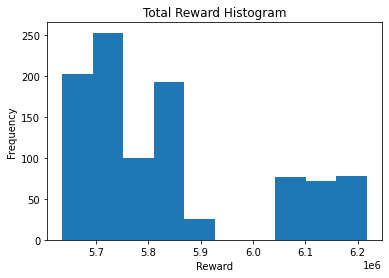

In [ ]:
# Just out of curiosity I want to see this histogram:
plt.hist(bangbangRunTotalRewards)
plt.title("Total Reward Histogram")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print("mean=", sum(bangbangRunTotalRewards) / len(bangbangRunTotalRewards))
print(st.t.interval(alpha=0.95, df=len(bangbangRunTotalRewards) - 1, loc=np.mean(bangbangRunTotalRewards), scale=st.sem(bangbangRunTotalRewards)))

mean= 5836544.544647314
(5825884.5974363815, 5847204.491858235)


In [ ]:
5825884.5974363815 - 5836544.544647314

-10659.94721093215

In [ ]:
sqrt(st.describe(bangbangRunTotalRewards).variance)

171783.115178215

In [ ]:
# Now we need to aggregate the data we just collected...  use a simple average for now (can also get st deviations and whatnot)

# Basically, I'm going to want to iterate through the simulation's data.

simulationPeriods = len(bangbangRunFDQtys[0])
numberSimulations = len(bangbangRunTotalRewards)
numberColumns = 7

# = [[0] * numberSimulations] * simulationPeriods

bangbangData = []

# For each period in the simulation...
for simPeriod in range(simulationPeriods):

  FDQtyDecision = []
  SDQtyDecision = []

  inventoryThisPd = []
  rewardThisPd = []
  FDStockoutsThisPd = []
  SDStockoutsThisPd = []
  SDPatientsNeverServedThisPd = []

  # For each simulation...
  for simRunNo in range(numberSimulations):
  
    FDQtyDecision.append(bangbangRunFDQtys[simRunNo][simPeriod])
    SDQtyDecision.append(bangbangRunSDQtys[simRunNo][simPeriod])
    inventoryThisPd.append(bangbangRunInventories[simRunNo][simPeriod])
    rewardThisPd.append(bangbangRunPeriodRewards[simRunNo][simPeriod])
    FDStockoutsThisPd.append(bangbangRunFDStockouts[simRunNo][simPeriod])
    SDStockoutsThisPd.append(bangbangRunSDStockouts[simRunNo][simPeriod])
    SDPatientsNeverServedThisPd.append(bangbangRunNeverServedSDPatients[simRunNo][simPeriod])

  avgFDQty = sum(FDQtyDecision)/len(FDQtyDecision)
  avgSDQty = sum(SDQtyDecision)/len(SDQtyDecision)
  avgInv = sum(inventoryThisPd)/len(inventoryThisPd)
  avgRew = sum(rewardThisPd)/len(rewardThisPd)
  avgFDStockout = sum(FDStockoutsThisPd)/len(FDStockoutsThisPd)
  avgSDStockout = sum(SDStockoutsThisPd)/len(SDStockoutsThisPd)
  avgSDPatientNeverServed = sum(SDPatientsNeverServedThisPd)/len(SDPatientsNeverServedThisPd)
  bangbangData.append({"period": simPeriod, "FDQty": avgFDQty, "SDQty": avgSDQty, "inventory": avgInv, "reward": avgRew, "FDStockoutQty": avgFDStockout ,"SDStockoutQty": avgSDStockout, "SDPatientsNeverServed": avgSDPatientNeverServed})



avgReward = sum(bangbangRunTotalRewards) / len(bangbangRunTotalRewards)
print(avgReward)

5836544.544647314


In [ ]:
# Convert to using the older variables (skip if you're just looking at one simulation)

bangbangFDQtys = [i["FDQty"] for i in bangbangData]
bangbangSDQtys = [i["SDQty"] for i in bangbangData]
bangbangPeriodRewards = [i["reward"] for i in bangbangData]
bangbangInventories = [i["inventory"] for i in bangbangData]
bangbangFDStockouts = [i["FDStockoutQty"] for i in bangbangData]
bangbangSDStockouts = [i["SDStockoutQty"] for i in bangbangData]
bangbangSDPatientsNeverServed = [i["SDPatientsNeverServed"] for i in bangbangData]

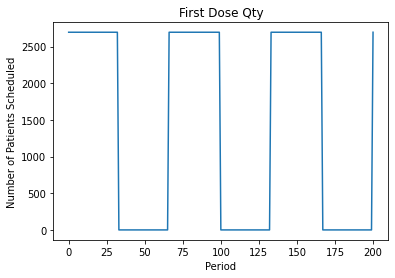

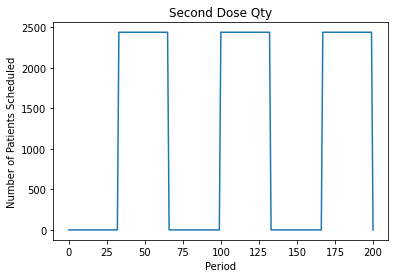

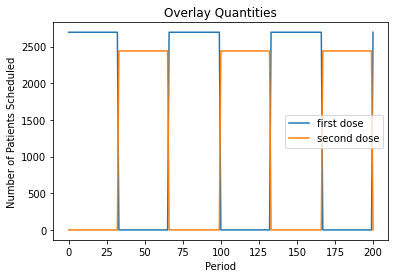

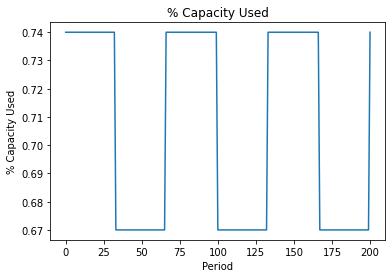

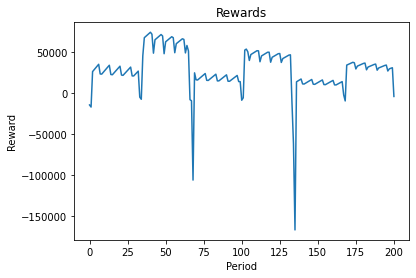

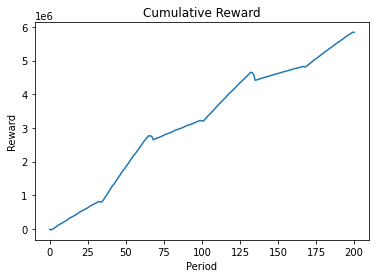

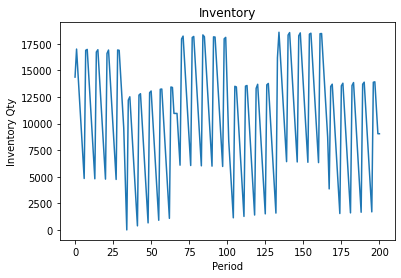

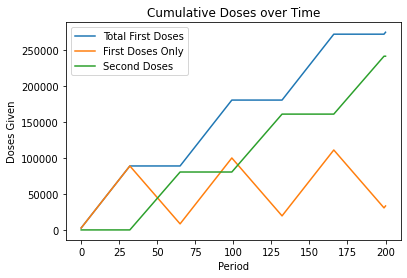

Total First Doses Given (Average): 274645.6968879717
Total Second Doses Given (Average): 238554.62360915449



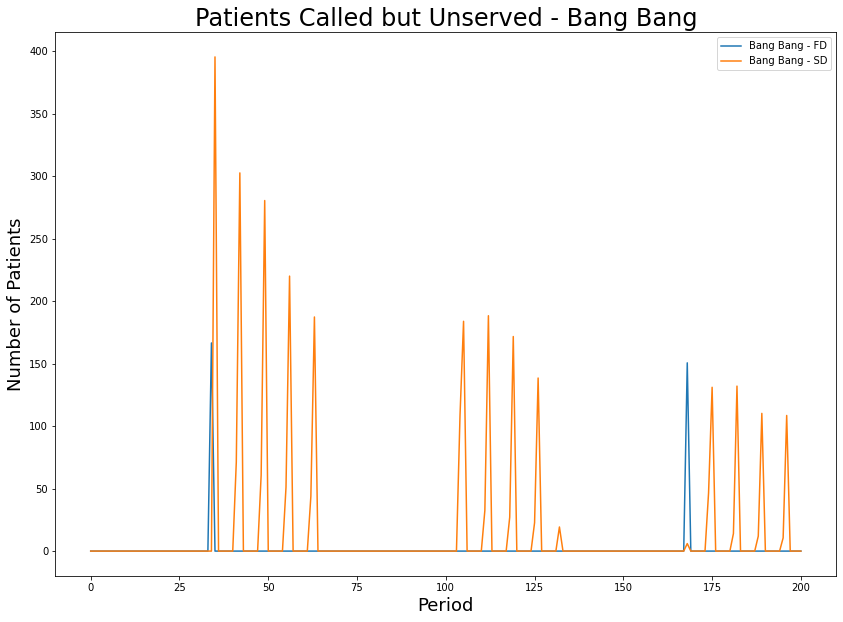

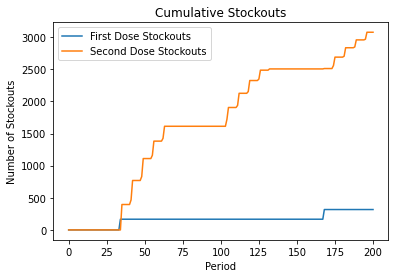

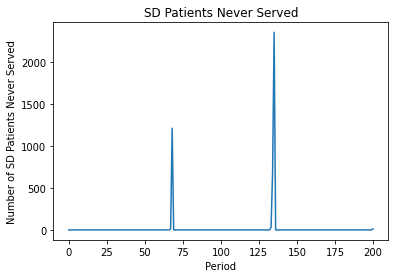

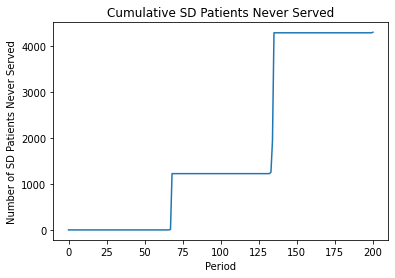

Cumulative SD Patients Never Served: 4304.6019813355715
Percentage of total SD Patients: 0.018044512892729292


In [ ]:
# Below plots are for a single run...

# First Dose
plt.plot(bangbangFDQtys)
plt.title("First Dose Qty")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.show()

# Second Dose
plt.plot(bangbangSDQtys)
plt.title("Second Dose Qty")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.show()

# Overlay
plt.plot(bangbangFDQtys, label="first dose")
plt.plot(bangbangSDQtys, label="second dose")
plt.title("Overlay Quantities")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.legend()
plt.show()

# Capacity Check
plt.plot(np.add(bangbangFDQtys, bangbangSDQtys)/capacity)
plt.title("% Capacity Used")
plt.xlabel("Period")
plt.ylabel("% Capacity Used")
plt.show()

# Reward
plt.plot(bangbangPeriodRewards)
plt.title("Rewards")
plt.xlabel("Period")
plt.ylabel("Reward")
plt.show()

# cumulative sum
def Cumulative(l):
   new = []
   cumsum = 0
   for element in l:
      cumsum += element
      new.append(cumsum)
   return new

# Cumulative Reward
plt.plot(Cumulative(bangbangPeriodRewards))
plt.title("Cumulative Reward")
plt.xlabel("Period")
plt.ylabel("Reward")
plt.show()

# Inventory
plt.plot(bangbangInventories)
plt.title("Inventory")
plt.xlabel("Period")
plt.ylabel("Inventory Qty")
plt.show()

# Cumulative FDs and SDs
plt.plot(Cumulative(bangbangFDQtys), label="Total First Doses")
plt.plot(np.subtract(Cumulative(bangbangFDQtys), Cumulative(bangbangSDQtys)), label="First Doses Only")
plt.plot(Cumulative(bangbangSDQtys), label="Second Doses")
#plt.plot(Cumulative(FDQtys)) - Cumulative(SDQtys))
plt.title("Cumulative Doses over Time")
plt.xlabel("Period")
plt.ylabel("Doses Given")
plt.legend()
plt.show()

bangbangAvgFDServed = Cumulative(bangbangFDQtys)[len(bangbangFDQtys) - 1] - Cumulative(bangbangFDStockouts)[len(bangbangFDStockouts) - 1]
bangbangAvgSDServed = Cumulative(bangbangSDQtys)[len(bangbangSDQtys) - 1] - Cumulative(bangbangSDStockouts)[len(bangbangSDStockouts) - 1]

print("Total First Doses Given (Average):", bangbangAvgFDServed)
print("Total Second Doses Given (Average):", bangbangAvgSDServed)
print()

# Stockouts
plt.figure(figsize=(14, 10))
plt.plot(bangbangFDStockouts, label="Bang Bang - FD")
plt.plot(bangbangSDStockouts, label="Bang Bang - SD")
plt.title("Patients Called but Unserved - Bang Bang", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients", fontsize=18)
plt.legend()
plt.show()

# Cumulative Stockouts
plt.plot(Cumulative(bangbangFDStockouts), label="First Dose Stockouts")
plt.plot(Cumulative(bangbangSDStockouts), label="Second Dose Stockouts")
plt.title("Cumulative Stockouts")
plt.xlabel("Period")
plt.ylabel("Number of Stockouts")
plt.legend()
plt.show()

# SD Patients never served
plt.plot(bangbangSDPatientsNeverServed)
plt.title("SD Patients Never Served")
plt.xlabel("Period")
plt.ylabel("Number of SD Patients Never Served")
plt.show()

# Cumulative SD Patients never served
plt.plot(Cumulative(bangbangSDPatientsNeverServed))
plt.title("Cumulative SD Patients Never Served")
plt.xlabel("Period")
plt.ylabel("Number of SD Patients Never Served")
plt.show()

print("Cumulative SD Patients Never Served:", Cumulative(bangbangSDPatientsNeverServed)[len(bangbangSDPatientsNeverServed) - 1])
print("Percentage of total SD Patients:", Cumulative(bangbangSDPatientsNeverServed)[len(bangbangSDPatientsNeverServed) - 1] / bangbangAvgSDServed)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


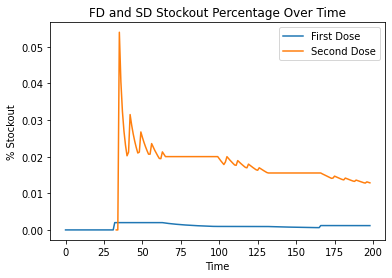

In [ ]:
bangbangFDTimeAdjusted = bangbangFDQtys[2:]
bangbangSDTimeAdjusted = bangbangSDQtys[:-2]
bangbangFDStockoutsTimeAdjusted = bangbangFDStockouts[2:]
bangbangSDStockoutsTimeAdjusted = bangbangSDStockouts[:-2]

plt.plot(np.divide(Cumulative(bangbangFDStockoutsTimeAdjusted), Cumulative(bangbangFDTimeAdjusted)), label="First Dose")
plt.plot(np.divide(Cumulative(bangbangSDStockoutsTimeAdjusted), Cumulative(bangbangSDTimeAdjusted)), label="Second Dose")
plt.title("FD and SD Stockout Percentage Over Time")
plt.xlabel("Time")
plt.ylabel("% Stockout")
plt.legend()
plt.show()

##### Optimize Policy Parameters

In [ ]:
# Old params
FDPatients = 1 / 1.3
SDPatients = (1 - 2 * FDNoShowProb) / 1.3


In [ ]:
printouts = False
printThresh = 200
num_simulations = 500

# Period of 66 seems to work best for this simulation
periodLength = 64

bangbangFDPatients = []
bangbangSDPatients = []
bangbangTrialRewards = []

game = TwoDoseVaccineEnv()


for FDPatientQty in range(76 - 4, 76 + 5, 1):
  for SDPatientQty in range(68 - 4, 68 + 5, 1):

    FDPatients = FDPatientQty / 100
    SDPatients = SDPatientQty / 100

    print("FDPatientPct", FDPatients, ", SDPatientPct", SDPatients)

    bangbangRunTotalRewards = []

    for trial in range(num_simulations):
      game.reset()
      totReward = 0
      done = False
      i = 1


      obs = game.state
      if printouts:
        print("Starting State")
        print("Observation Space")
        print("Time", obs[0])
        print("Inventory", obs[1])
        print("FD Vaccines Given (planned) this period", obs[2])
        print("FD Patients Arriving this period", obs[3])
        print("SD Vaccines Given (planned) this period", obs[4])
        print("Number of FD Stockouts", obs[5])
        print("Number of SD Stockouts", obs[6])
        print("Number of FD Orders next period", obs[7])
        print("Number of FD Orders 2 periods from now", obs[8])
        print("Number of newly eligible SD patients", obs[9])
        print("SD patients with 6 days left", obs[10])
        print("SD patients with 5 days left", obs[11])
        print("SD patients with 4 days left", obs[12])
        print("SD patients with 3 days left", obs[13])
        print("SD patients with 2 days left", obs[14])
        print("SD patients with 1 day left", obs[15])
        print()

      while not done:

        #prediction = model.predict(obs, deterministic=True)
        action = []

        # Policy idea:  Assuming period = 66
        if (i % periodLength) < (periodLength / 2):
          action = [FDPatients, 0]
        else:
          action = [0, SDPatients]

        obs, rewards, done, info = game.step(action)
        #print("Observation", obs)

        if obs[0] <= printThresh and printouts:
          print()
          print("Period", i)
          print("Action")
          print("FD Qty", action[0] * capacity)
          print("SD Qty", action[1] * capacity)
          print()
          print("Observation Space")
          print("Time", obs[0])
          print("Inventory", obs[1])
          print("FD Vaccines Given (planned) this period", obs[2])
          print("FD Patients Arriving this period", obs[3])
          print("SD Vaccines Given (planned) this period", obs[4])
          print("Number of FD Stockouts", obs[5])
          print("Number of SD Stockouts", obs[6])
          print("Number of FD Orders next period", obs[7])
          print("Number of FD Orders 2 periods from now", obs[8])
          print("Number of newly eligible SD patients", obs[9])
          print("SD patients with 6 days left", obs[10])
          print("SD patients with 5 days left", obs[11])
          print("SD patients with 4 days left", obs[12])
          print("SD patients with 3 days left", obs[13])
          print("SD patients with 2 days left", obs[14])
          print("SD patients with 1 day left", obs[15])

          print("Rewards", round(rewards, 2))
          print()
        totReward += rewards
        i += 1

      if printouts:
        print()
      #print("Total Reward=", totReward)
      bangbangRunTotalRewards.append(totReward)


      avgReward = sum(bangbangRunTotalRewards) / len(bangbangRunTotalRewards)
      #print(avgReward)# Now we need to aggregate the data we just collected...  use a simple average for now (can also get st deviations and whatnot)

      bangbangFDPatients.append(FDPatientQty)
      bangbangSDPatients.append(SDPatientQty)
      bangbangTrialRewards.append(avgReward)

FDPatientPct 0.72 , SDPatientPct 0.64
FDPatientPct 0.72 , SDPatientPct 0.65
FDPatientPct 0.72 , SDPatientPct 0.66
FDPatientPct 0.72 , SDPatientPct 0.67
FDPatientPct 0.72 , SDPatientPct 0.68
FDPatientPct 0.72 , SDPatientPct 0.69
FDPatientPct 0.72 , SDPatientPct 0.7
FDPatientPct 0.72 , SDPatientPct 0.71
FDPatientPct 0.72 , SDPatientPct 0.72
FDPatientPct 0.73 , SDPatientPct 0.64
FDPatientPct 0.73 , SDPatientPct 0.65
FDPatientPct 0.73 , SDPatientPct 0.66
FDPatientPct 0.73 , SDPatientPct 0.67
FDPatientPct 0.73 , SDPatientPct 0.68
FDPatientPct 0.73 , SDPatientPct 0.69
FDPatientPct 0.73 , SDPatientPct 0.7
FDPatientPct 0.73 , SDPatientPct 0.71
FDPatientPct 0.73 , SDPatientPct 0.72
FDPatientPct 0.74 , SDPatientPct 0.64
FDPatientPct 0.74 , SDPatientPct 0.65
FDPatientPct 0.74 , SDPatientPct 0.66
FDPatientPct 0.74 , SDPatientPct 0.67
FDPatientPct 0.74 , SDPatientPct 0.68
FDPatientPct 0.74 , SDPatientPct 0.69
FDPatientPct 0.74 , SDPatientPct 0.7
FDPatientPct 0.74 , SDPatientPct 0.71
FDPatientPct 0.

In [ ]:
print(avgReward)

4155135.206991273


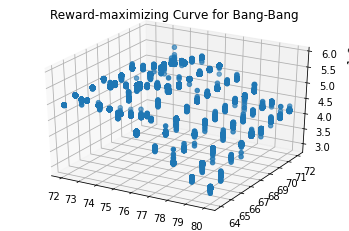

In [ ]:
fig = plt.figure()
ax = plt.axes(projection ='3d')

# plotting code
ax.scatter(bangbangFDPatients, bangbangSDPatients, bangbangTrialRewards, 'blue')
ax.set_title('Reward-maximizing Curve for Bang-Bang')
plt.show()

In [ ]:
# find maximum value
print("Maximum reward", max(bangbangTrialRewards))
print("At Index", bangbangTrialRewards.index(max(bangbangTrialRewards)))
bestIdx2 = bangbangTrialRewards.index(max(bangbangTrialRewards))
print("FDQty", bangbangFDPatients[bestIdx2] / 100)
print("SDQty", bangbangSDPatients[bestIdx2] / 100)

Maximum reward 5898278.597826464
At Index 10501
FDQty 0.74
SDQty 0.67


Pfizer

Maximum reward 6094383.8271602485

FDQty 0.74

SDQty 0.67



---
Moderna

Maximum reward 6067652.13

FDQty 0.74

SDQty 0.68


## Load the TPU-54 Best RL (Moderna)

In [ ]:
#def unpickle(fName):
#  f = open(fName, "rb")
#  d = pickle.load(f)
#  f.close()
#  return d

game = TwoDoseVaccineEnv()
model = TRPO.load("drive/MyDrive/Thesis/" + "TPU - 54 - Kahuna 4-21-2021.zip", env=game)
#totalRewards = unpickle("drive/MyDrive/Thesis/" + "TPU - " + str(54) + " - Kahuna Training Data 4-21-2021")
#game = TwoDoseVaccineEnv()
#model = TRPO.load("drive/MyDrive/Thesis/" + "Moderna Modsel 7 4-23-2021.zip", env=game)





Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please use `layer.__call__` method instead.











## Create + Train the Moderna Model

In [ ]:
'''
game = TwoDoseVaccineEnv()

# Create the "model" for our RL
model = TRPO(MlpPolicy, game, verbose=0)

totalRewards = []
'''

In [ ]:
'''
numTimeSteps = 1000
doneNow = False
#currentBest = 6067652.13

while not doneNow:
  # Have the model learn for numTimeSteps more timesteps, and append the number of iterations to our list
  model.learn(total_timesteps=numTimeSteps)

  rewList = []

  for t in range(30):

    done = False
    obs = game.reset()

    totReward = 0

    while not done:
      action, _states = model.predict(obs, deterministic=True)
      obs, rewards, done, info = game.step(action)
      totReward += rewards

    rewList.append(totReward)

  iterAvgReward = sum(rewList) / len(rewList)

  totalRewards.append(iterAvgReward)
  print("Iter", len(totalRewards), iterAvgReward)

  if iterAvgReward > 6100000:
    doneNow = True
    currentBest = iterAvgReward

plt.title("Total Rewards")
plt.plot(totalRewards)
plt.show()
'''

Iter 7571 5762886.1636298485
Iter 7572 5715354.923635373
Iter 7573 5741386.86002035
Iter 7574 5733224.132010946
Iter 7575 5540644.281822795
Iter 7576 5471688.210689087
Iter 7577 5690504.044121946
Iter 7578 5528838.387880084
Iter 7579 5584431.552702532
Iter 7580 5538466.1189415
Iter 7581 5530722.779666188
Iter 7582 5493859.190984539
Iter 7583 5499472.42992518
Iter 7584 5454999.791426927
Iter 7585 5371970.502668083
Iter 7586 5578798.771964205
Iter 7587 5641026.987942744
Iter 7588 5699171.154072358
Iter 7589 5623167.674779619
Iter 7590 5848821.292144622
Iter 7591 5863653.023927648
Iter 7592 5909803.411381366
Iter 7593 5943587.256178957
Iter 7594 5851848.374597915
Iter 7595 5775973.781973158
Iter 7596 5822353.875571151
Iter 7597 5740019.751166407
Iter 7598 5783040.385684905
Iter 7599 5814855.961440743
Iter 7600 5796138.291835393
Iter 7601 5841498.572172585
Iter 7602 5869546.460828767
Iter 7603 5735069.710339289
Iter 7604 5733305.46899085
Iter 7605 5692353.924758029
Iter 7606 5639750.870022

In [ ]:
#recordNo = 1

In [ ]:
'''
fname = "Pfizer Model " + str(recordNo) + " 4-25-2021"
fname2 = "Pfizer Model " + str(recordNo) + " Training Data 4-25-2021"

model.save("drive/MyDrive/Thesis/" + fname)

# Save the list
pickling_on = open("drive/MyDrive/Thesis/" + fname2,"wb")
pickle.dump(totalRewards, pickling_on)
pickling_on.close()

print(recordNo)
recordNo += 1
'''

2


## Test Prediction

In [ ]:
printouts = False
printThresh = 200
num_simulations = 1000

simRunTotalRewards = []
simRunFDQtys = []
simRunSDQtys = []
simRunInventories = []
simRunPeriodRewards = []
simRunFDStockouts = []
simRunSDStockouts = []
simRunNeverServedSDPatients = []

for simNum in range(num_simulations):
  game.reset()
  totReward = 0
  done = False
  i = 1

  FDQtys = []
  SDQtys = []
  inventories = []
  periodRewards = []
  FDStockouts = []
  SDStockouts = []
  SDPatientsNeverServed = []


  obs = game.state
  if printouts:
    print("Starting State")
    print("Observation Space")
    print("Time", obs[0])
    print("Inventory", obs[1])
    print("FD Vaccines Given (planned) this period", obs[2])
    print("FD Patients Arriving this period", obs[3])
    print("SD Vaccines Given (planned) this period", obs[4])
    print("Number of FD Stockouts", obs[5])
    print("Number of SD Stockouts", obs[6])
    print("Number of FD Orders next period", obs[7])
    print("Number of FD Orders 2 periods from now", obs[8])
    print("Number of newly eligible SD patients", obs[9])
    print("SD patients with 6 days left", obs[10])
    print("SD patients with 5 days left", obs[11])
    print("SD patients with 4 days left", obs[12])
    print("SD patients with 3 days left", obs[13])
    print("SD patients with 2 days left", obs[14])
    print("SD patients with 1 day left", obs[15])
    print()

  SDPatientsThatNeedVaxThisPd = obs[15]


  while not done:

    prediction = model.predict(obs, deterministic=True)

    FDQtys.append(prediction[0][0] * capacity)
    SDQtys.append(prediction[0][1] * capacity)

    obs, rewards, done, info = game.step(prediction[0])
    #print("Observation", obs)

    if obs[0] <= printThresh and printouts:
      print()
      print("Period", i)
      print("Action")
      print("FD Qty", prediction[0][0] * capacity)
      print("SD Qty", prediction[0][1] * capacity)
      print()
      print("Observation Space")
      print("Time", obs[0])
      print("Inventory", obs[1])
      print("FD Vaccines Given (planned) this period", obs[2])
      print("FD Patients Arriving this period", obs[3])
      print("SD Vaccines Given (planned) this period", obs[4])
      print("Number of FD Stockouts", obs[5])
      print("Number of SD Stockouts", obs[6])
      print("Number of FD Orders next period", obs[7])
      print("Number of FD Orders 2 periods from now", obs[8])
      print("Number of newly eligible SD patients", obs[9])
      print("SD patients with 6 days left", obs[10])
      print("SD patients with 5 days left", obs[11])
      print("SD patients with 4 days left", obs[12])
      print("SD patients with 3 days left", obs[13])
      print("SD patients with 2 days left", obs[14])
      print("SD patients with 1 day left", obs[15])

      print("Rewards", round(rewards, 2))
      print()
    periodRewards.append(rewards)
    inventories.append(obs[1])
    FDStockouts.append(obs[5])
    SDStockouts.append(obs[6])

    # Calculate the number of patients that went unserved:

    SDPatientsPlanned = prediction[0][1] * capacity
    SDStockoutsThisPd = obs[6]
    SDServedThisPd = SDPatientsPlanned - SDStockoutsThisPd

    if SDServedThisPd >= SDPatientsThatNeedVaxThisPd:
      SDPatientsThatNeverGotSD = 0
    else:
      SDPatientsThatNeverGotSD = max(SDPatientsThatNeedVaxThisPd - SDServedThisPd, 0)

    SDPatientsNeverServed.append(SDPatientsThatNeverGotSD)

    SDPatientsThatNeedVaxThisPd = obs[15]

    totReward += rewards
    i += 1

  #if totReward < 4000000:
  #  i -= 1
  #  simNum -= 1
  #else:
  if printouts:
    print()
  print("Total Reward=", totReward)
  simRunTotalRewards.append(totReward)
  simRunFDQtys.append(FDQtys)
  simRunSDQtys.append(SDQtys)
  simRunInventories.append(inventories)
  simRunPeriodRewards.append(periodRewards)
  simRunFDStockouts.append(FDStockouts)
  simRunSDStockouts.append(SDStockouts)
  simRunNeverServedSDPatients.append(SDPatientsNeverServed)

Total Reward= 6333053.262839426
Total Reward= 6392736.479521896
Total Reward= 6057960.817691416
Total Reward= 6582291.56667516
Total Reward= 6201775.432669506
Total Reward= 6138288.445647556
Total Reward= 5786546.672109671
Total Reward= 6323138.248120715
Total Reward= 6420669.447566031
Total Reward= 6357516.298499738
Total Reward= 5962365.300914529
Total Reward= 6431310.972898931
Total Reward= 6179898.125371778
Total Reward= 6489598.168146822
Total Reward= 6334176.561319448
Total Reward= 6448479.265024293
Total Reward= 6183619.749956397
Total Reward= 6332722.511986744
Total Reward= 6419285.740609729
Total Reward= 6125309.191253335
Total Reward= 6535557.393315647
Total Reward= 6363352.624931639
Total Reward= 5975236.73214039
Total Reward= 6061038.840096411
Total Reward= 6169889.305557776
Total Reward= 6754714.745765147
Total Reward= 6092853.74977503
Total Reward= 5891534.5940553835
Total Reward= 6523033.854902011
Total Reward= 5802617.376735319
Total Reward= 6348477.338134048
Total Rewa

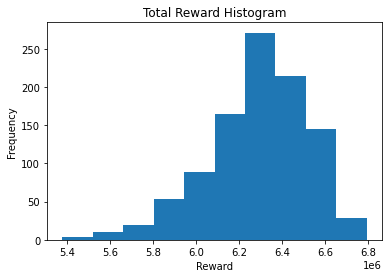

In [ ]:
# Just out of curiosity I want to see this histogram:
plt.hist(simRunTotalRewards)
plt.title("Total Reward Histogram")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.show()

In [ ]:
print("Mean=", np.mean(simRunTotalRewards))
print(st.t.interval(alpha=0.95, df=len(simRunTotalRewards) - 1, loc=np.mean(simRunTotalRewards), scale=st.sem(simRunTotalRewards)))

Mean= 6292057.763939147
(6277620.554880417, 6306494.972997877)


In [ ]:
np.mean(simRunTotalRewards) - st.t.interval(alpha=0.95, df=len(simRunTotalRewards) - 1, loc=np.mean(simRunTotalRewards), scale=st.sem(simRunTotalRewards))[0]

14437.209058729932

In [ ]:
sqrt(st.describe(simRunTotalRewards).variance)

232653.00451447858

In [ ]:
# Now we need to aggregate the data we just collected...  use a simple average for now (can also get st deviations and whatnot)

# Basically, I'm going to want to iterate through the simulation's data.

simulationPeriods = len(simRunFDQtys[0])
numberSimulations = len(simRunTotalRewards)
numberColumns = 7

# = [[0] * numberSimulations] * simulationPeriods

simulationData = []

# For each period in the simulation...
for simPeriod in range(simulationPeriods):

  FDQtyDecision = []
  SDQtyDecision = []

  inventoryThisPd = []
  rewardThisPd = []
  FDStockoutsThisPd = []
  SDStockoutsThisPd = []
  SDPatientsNeverServedThisPd = []

  # For each simulation...
  for simRunNo in range(numberSimulations):
  
    FDQtyDecision.append(simRunFDQtys[simRunNo][simPeriod])
    SDQtyDecision.append(simRunSDQtys[simRunNo][simPeriod])
    inventoryThisPd.append(simRunInventories[simRunNo][simPeriod])
    rewardThisPd.append(simRunPeriodRewards[simRunNo][simPeriod])
    FDStockoutsThisPd.append(simRunFDStockouts[simRunNo][simPeriod])
    SDStockoutsThisPd.append(simRunSDStockouts[simRunNo][simPeriod])
    SDPatientsNeverServedThisPd.append(simRunNeverServedSDPatients[simRunNo][simPeriod])

  avgFDQty = sum(FDQtyDecision)/len(FDQtyDecision)
  avgSDQty = sum(SDQtyDecision)/len(SDQtyDecision)
  avgInv = sum(inventoryThisPd)/len(inventoryThisPd)
  avgRew = sum(rewardThisPd)/len(rewardThisPd)
  avgFDStockout = sum(FDStockoutsThisPd)/len(FDStockoutsThisPd)
  avgSDStockout = sum(SDStockoutsThisPd)/len(SDStockoutsThisPd)
  avgSDPatientNeverServed = sum(SDPatientsNeverServedThisPd)/len(SDPatientsNeverServedThisPd)
  simulationData.append({"period": simPeriod, "FDQty": avgFDQty, "SDQty": avgSDQty, "inventory": avgInv, "reward": avgRew, "FDStockoutQty": avgFDStockout ,"SDStockoutQty": avgSDStockout, "SDPatientsNeverServed": avgSDPatientNeverServed})



avgReward = sum(simRunTotalRewards) / len(simRunTotalRewards)
print(avgReward)

6292057.763939146


**Pfizer**

Old reward:  6318136.116167635

CI: (6303967.85558452, 6332304.376750738)

Done with TPU - 54



---



**Moderna**

Old reward:  6113622.50

CI:  (6099992.143121516, 6127252.858345307)

Done with Moderna - 7

In [ ]:
# Convert to using the older variables (skip if you're just looking at one simulation)

simFDQtys = [i["FDQty"] for i in simulationData]
simSDQtys = [i["SDQty"] for i in simulationData]
simPeriodRewards = [i["reward"] for i in simulationData]
simInventories = [i["inventory"] for i in simulationData]
simFDStockouts = [i["FDStockoutQty"] for i in simulationData]
simSDStockouts = [i["SDStockoutQty"] for i in simulationData]
simSDPatientsNeverServed = [i["SDPatientsNeverServed"] for i in simulationData]

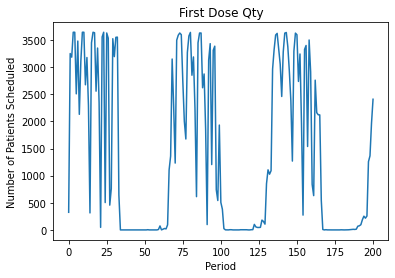

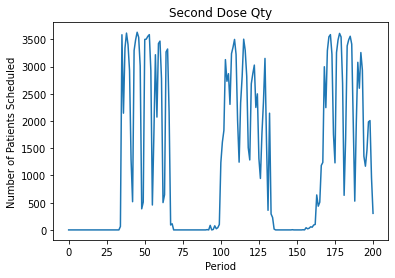

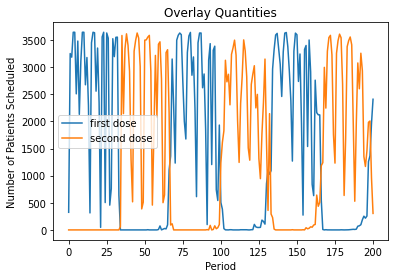

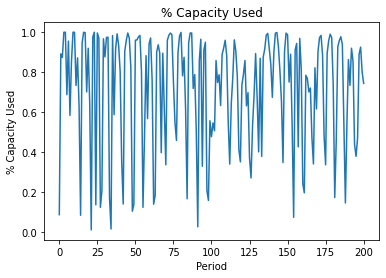

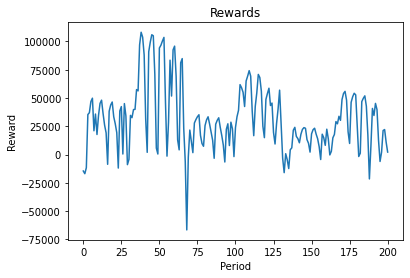

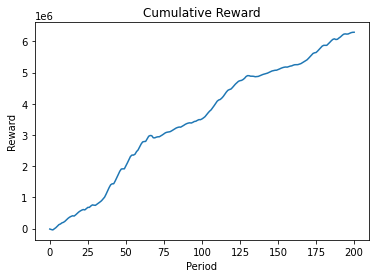

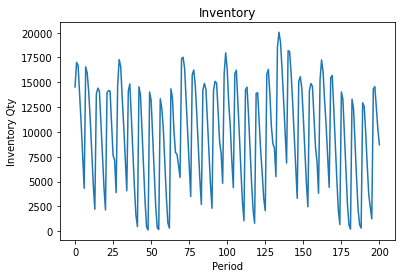

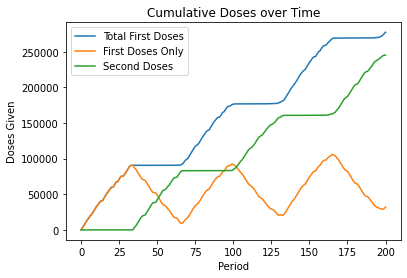

Total First Doses Given (Average): 276528.85104404815
Total Second Doses Given (Average): 238747.95544159104



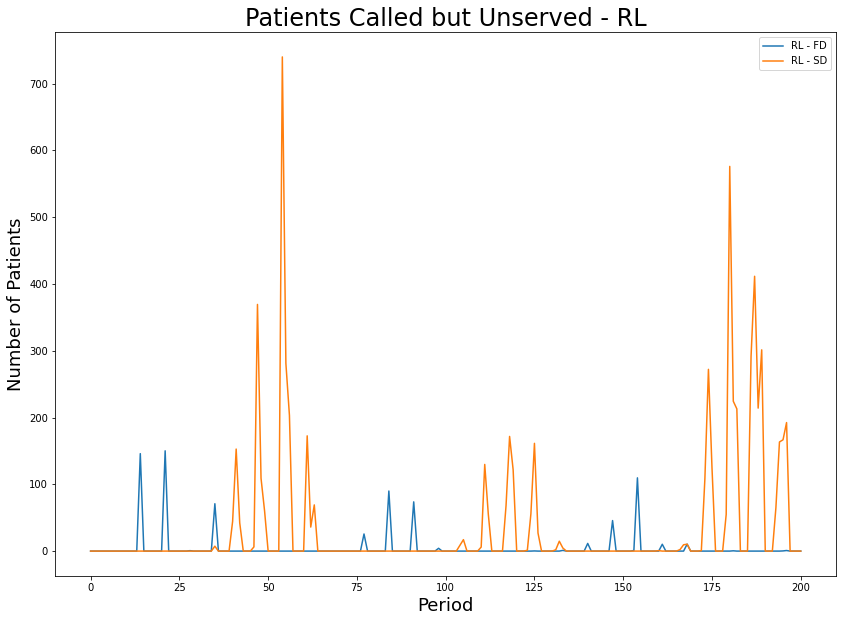

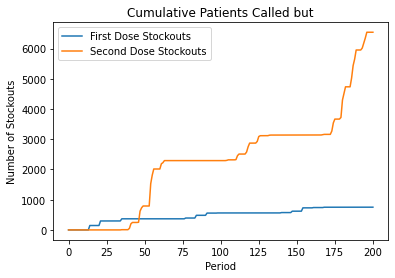

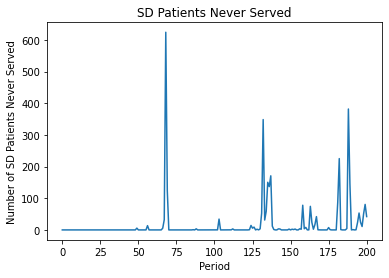

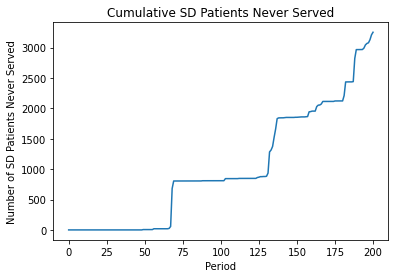

Cumulative SD Patients Never Served: 3252.885889365435
Percentage of total SD Patients: 0.013624769616765342


In [ ]:
# Below plots are for a single run...

# First Dose
plt.plot(simFDQtys)
plt.title("First Dose Qty")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.show()

# Second Dose
plt.plot(simSDQtys)
plt.title("Second Dose Qty")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.show()

# Overlay
plt.plot(simFDQtys, label="first dose")
plt.plot(simSDQtys, label="second dose")
plt.title("Overlay Quantities")
plt.xlabel("Period")
plt.ylabel("Number of Patients Scheduled")
plt.legend()
plt.show()

# Capacity Check
plt.plot(np.add(simFDQtys, simSDQtys)/capacity)
plt.title("% Capacity Used")
plt.xlabel("Period")
plt.ylabel("% Capacity Used")
plt.show()

# Reward
plt.plot(simPeriodRewards)
plt.title("Rewards")
plt.xlabel("Period")
plt.ylabel("Reward")
plt.show()

# cumulative sum
def Cumulative(l):
   new = []
   cumsum = 0
   for element in l:
      cumsum += element
      new.append(cumsum)
   return new

# Cumulative Reward
plt.plot(Cumulative(simPeriodRewards))
plt.title("Cumulative Reward")
plt.xlabel("Period")
plt.ylabel("Reward")
plt.show()

# Inventory
plt.plot(simInventories)
plt.title("Inventory")
plt.xlabel("Period")
plt.ylabel("Inventory Qty")
plt.show()

# Cumulative FDs and SDs
plt.plot(Cumulative(simFDQtys), label="Total First Doses")
plt.plot(np.subtract(Cumulative(simFDQtys), Cumulative(simSDQtys)), label="First Doses Only")
plt.plot(Cumulative(simSDQtys), label="Second Doses")
#plt.plot(Cumulative(FDQtys)) - Cumulative(SDQtys))
plt.title("Cumulative Doses over Time")
plt.xlabel("Period")
plt.ylabel("Doses Given")
plt.legend()
plt.show()

simAvgFDServed = Cumulative(simFDQtys)[len(simFDQtys) - 1] - Cumulative(simFDStockouts)[len(simFDStockouts) - 1]
simAvgSDServed = Cumulative(simSDQtys)[len(simSDQtys) - 1] - Cumulative(simSDStockouts)[len(simSDStockouts) - 1]

print("Total First Doses Given (Average):", simAvgFDServed)
print("Total Second Doses Given (Average):", simAvgSDServed)
print()

# Stockouts
plt.figure(figsize=(14, 10))
plt.plot(simFDStockouts, label="RL - FD")
plt.plot(simSDStockouts, label="RL - SD")
plt.title("Patients Called but Unserved - RL", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients", fontsize=18)
plt.legend()
plt.show()

# Cumulative Stockouts
plt.plot(Cumulative(simFDStockouts), label="First Dose Stockouts")
plt.plot(Cumulative(simSDStockouts), label="Second Dose Stockouts")
plt.title("Cumulative Patients Called but")
plt.xlabel("Period")
plt.ylabel("Number of Stockouts")
plt.legend()
plt.show()

# SD Patients never served
plt.plot(simSDPatientsNeverServed)
plt.title("SD Patients Never Served")
plt.xlabel("Period")
plt.ylabel("Number of SD Patients Never Served")
plt.show()

# Cumulative SD Patients never served
plt.plot(Cumulative(simSDPatientsNeverServed))
plt.title("Cumulative SD Patients Never Served")
plt.xlabel("Period")
plt.ylabel("Number of SD Patients Never Served")
plt.show()
print("Cumulative SD Patients Never Served:", Cumulative(simSDPatientsNeverServed)[len(simSDPatientsNeverServed) - 1])
print("Percentage of total SD Patients:", Cumulative(simSDPatientsNeverServed)[len(simSDPatientsNeverServed) - 1] / simAvgSDServed)

### Time Adjusted Stockout %

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


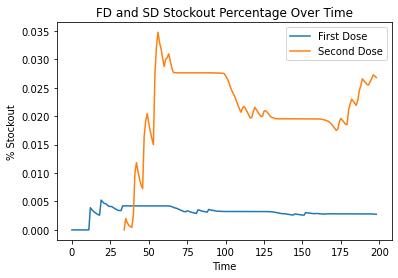

In [ ]:
simFDTimeAdjusted = simFDQtys[2:]
simSDTimeAdjusted = simSDQtys[:-2]
simFDStockoutsTimeAdjusted = simFDStockouts[2:]
simSDStockoutsTimeAdjusted = simSDStockouts[:-2]

plt.plot(np.divide(Cumulative(simFDStockoutsTimeAdjusted), Cumulative(simFDTimeAdjusted)), label="First Dose")
plt.plot(np.divide(Cumulative(simSDStockoutsTimeAdjusted), Cumulative(simSDTimeAdjusted)), label="Second Dose")
plt.title("FD and SD Stockout Percentage Over Time")
plt.xlabel("Time")
plt.ylabel("% Stockout")
plt.legend()
plt.show()

### Time-Adjusted Bang-Bang
One of the issues with making these plots is that the action is time-separated from the actual fulfillment of the order.  The following graph accounts for this disparity

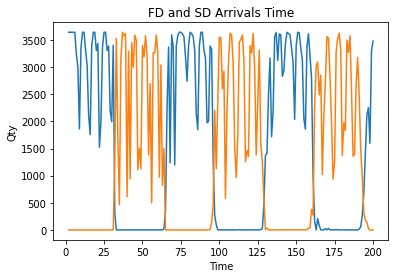

In [ ]:
simFDTimeAdjusted = simFDQtys[:-2]
simSDTimeAdjusted = simSDQtys[2:]

plt.plot(list(range(2, len(simFDTimeAdjusted) + 2)), simFDTimeAdjusted)
plt.plot(list(range(2, len(simSDTimeAdjusted) + 2)), simSDTimeAdjusted)
plt.title("FD and SD Arrivals Time")
plt.xlabel("Time")
plt.ylabel("Qty")
plt.show()

### Non-Discounted Rewards

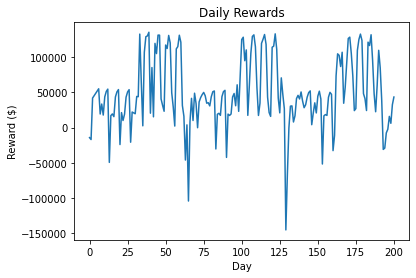

In [ ]:
simNonDiscountedRewards = []

for i in range(len(simPeriodRewards)):
  # Discount backwards

  simNonDiscountedRewards.append(simPeriodRewards[i]/(gamma**(i)))

plt.plot(simNonDiscountedRewards)
plt.title("Daily Rewards")
plt.xlabel("Day")
plt.ylabel("Reward ($)")
plt.show()

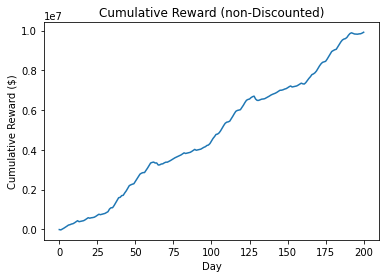

In [ ]:
# Non-discounted cumulative rewards
plt.plot(Cumulative(simNonDiscountedRewards))
plt.title("Cumulative Reward (non-Discounted)")
plt.xlabel("Day")
plt.ylabel("Cumulative Reward ($)")
plt.show()

In [ ]:
# Pickle the dataset

#pickling_on = open("drive/MyDrive/Thesis/Thesis Best Model Run Data","wb")
#pickle.dump(simulationData, pickling_on)
#pickling_on.close()

In [ ]:
# Pickle all elements of the data set that we keep records on...

#allStates = [simRunTotalRewards, simRunFDQtys, simRunSDQtys, simRunInventories, simRunPeriodRewards, simRunFDStockouts, simRunSDStockouts, simRunNeverServedSDPatients]

#pickling_on = open("drive/MyDrive/Thesis/Thesis All States TPU 54","wb")
#pickle.dump(allStates, pickling_on)
#pickling_on.close()

In [ ]:
#simulationData = unpickle("drive/MyDrive/Thesis/Thesis All States TPU 54")
#simulationData = unpickle("drive/MyDrive/Thesis/Thesis Best Model Run Data")

## Combined Plots

Now aggregate all of the results together w/ a combined plot

#### Reward Histogram

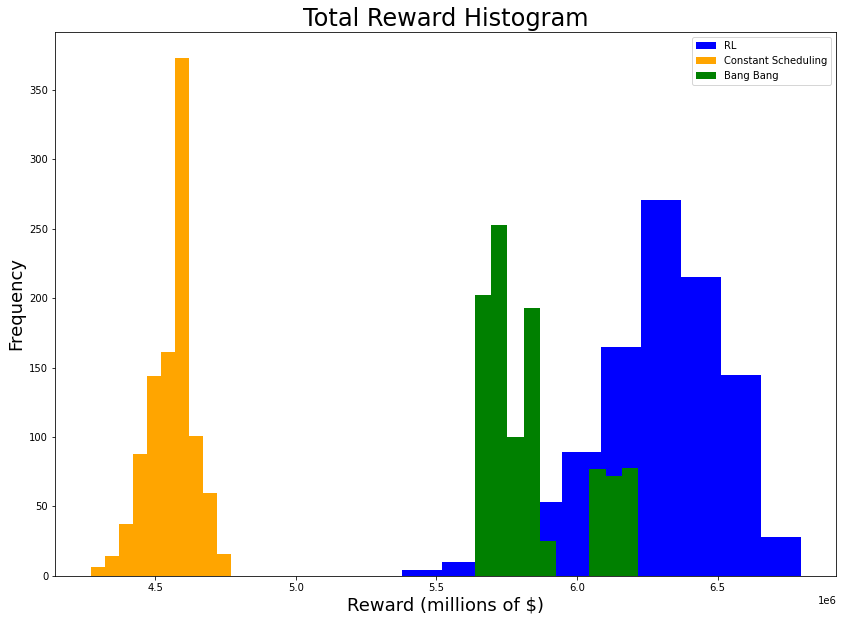

In [ ]:
# Just out of curiosity I want to see this histogram:
plt.figure(figsize=(14,10))
plt.hist(simRunTotalRewards, label="RL", color='blue')
plt.hist(compareRunTotalRewards, label="Constant Scheduling", color='orange')
plt.hist(bangbangRunTotalRewards, label="Bang Bang", color='green')
plt.title("Total Reward Histogram", fontsize=24)
plt.xlabel("Reward (millions of $)", fontsize=18)
plt.ylabel("Frequency", fontsize=18)
plt.legend()
plt.show()

#### First Dose

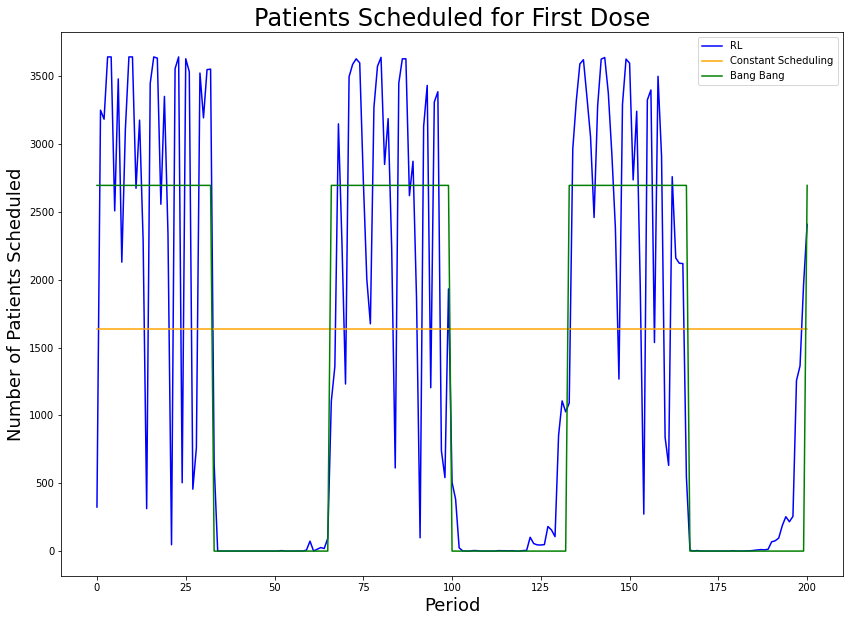

In [ ]:
# First Dose
plt.figure(figsize=(14,10))
plt.plot(simFDQtys, label="RL", color='blue')
plt.plot(compareFDQtys, label="Constant Scheduling", color='orange')
plt.plot(bangbangFDQtys, label="Bang Bang", color='green')
plt.title("Patients Scheduled for First Dose", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients Scheduled", fontsize=18)
plt.legend()
plt.show()

#### Second Dose

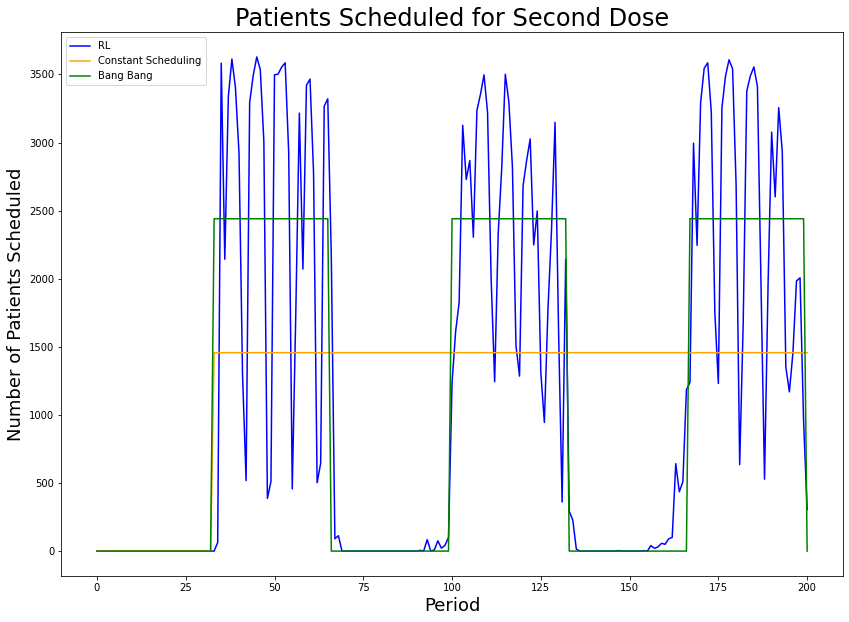

In [ ]:
# Second Dose
plt.figure(figsize=(14,10))
plt.plot(simSDQtys, label="RL", color='blue')
plt.plot(compareSDQtys, label="Constant Scheduling", color='orange')
plt.plot(bangbangSDQtys, label="Bang Bang", color='green')
plt.title("Patients Scheduled for Second Dose", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients Scheduled", fontsize=18)
plt.legend()
plt.show()

#### First Dose + Second Dose

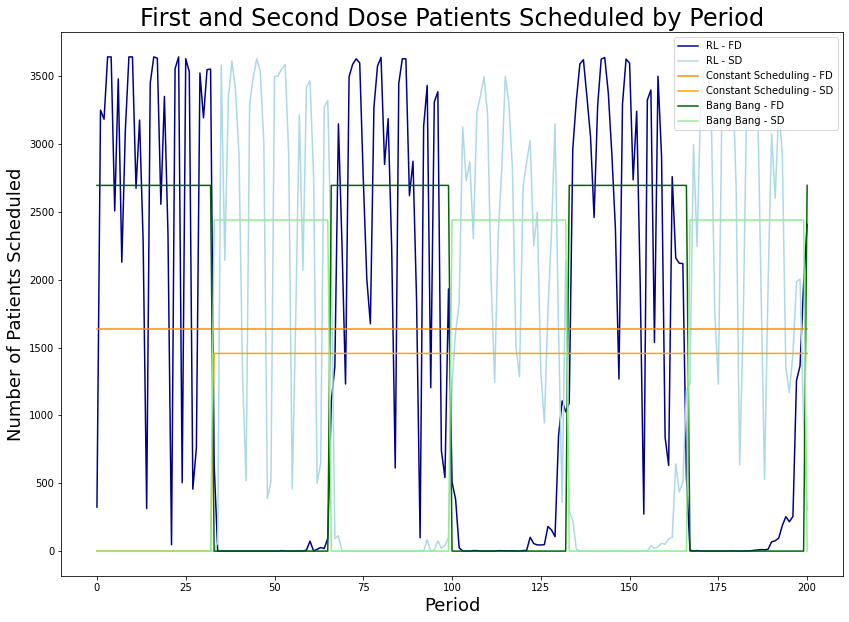

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(simFDQtys, label="RL - FD", color='darkblue')
plt.plot(simSDQtys, label="RL - SD", color='lightblue')
plt.plot(compareFDQtys, label="Constant Scheduling - FD", color='darkorange')
plt.plot(compareSDQtys, label="Constant Scheduling - SD", color='orange')
plt.plot(bangbangFDQtys, label="Bang Bang - FD", color='darkgreen')
plt.plot(bangbangSDQtys, label="Bang Bang - SD", color='lightgreen')
plt.title("First and Second Dose Patients Scheduled by Period", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients Scheduled", fontsize=18)
plt.legend()
plt.show()

##### Separated out:

RL

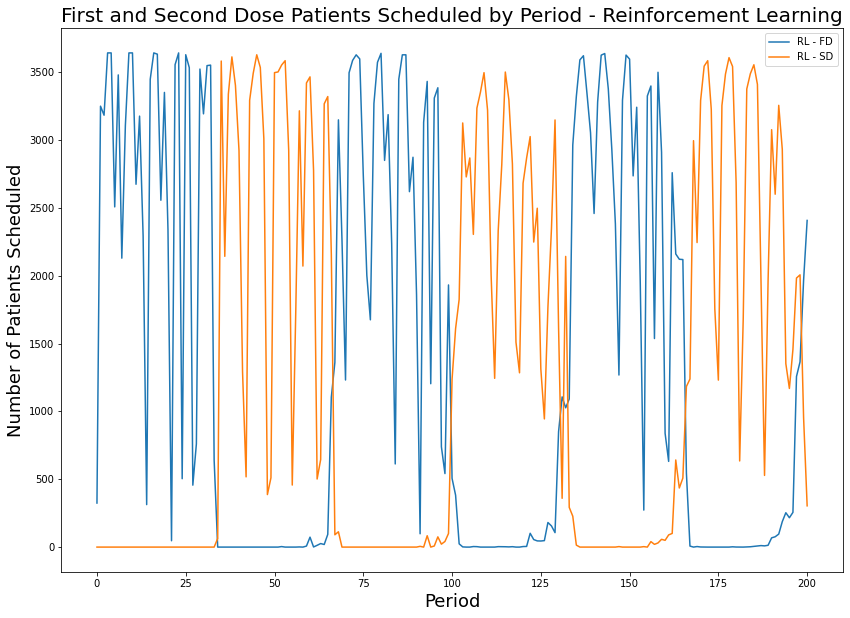

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(simFDQtys, label="RL - FD")
plt.plot(simSDQtys, label="RL - SD")
plt.title("First and Second Dose Patients Scheduled by Period - Reinforcement Learning", fontsize=20)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients Scheduled", fontsize=18)
plt.legend()
plt.show()

Constant Scheduling

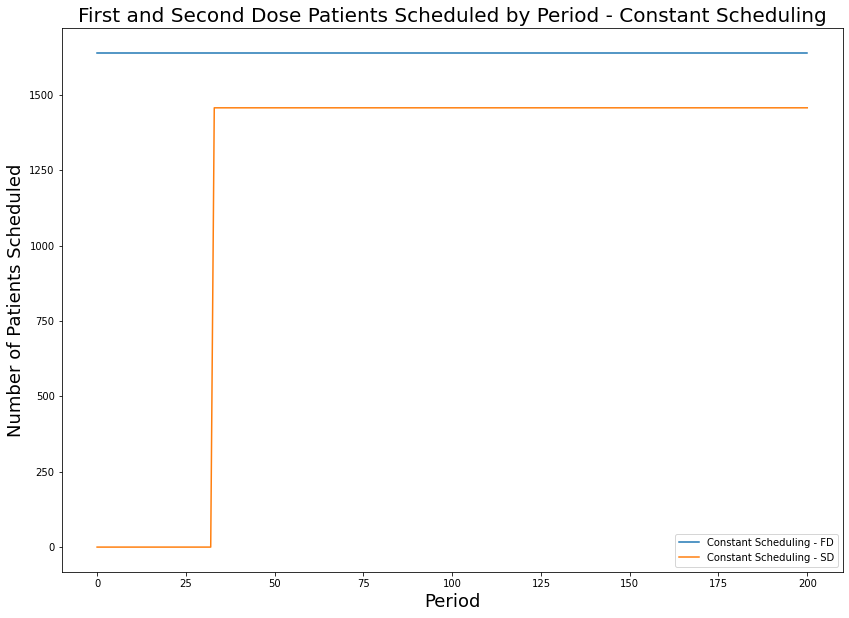

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(compareFDQtys, label="Constant Scheduling - FD")
plt.plot(compareSDQtys, label="Constant Scheduling - SD")
plt.title("First and Second Dose Patients Scheduled by Period - Constant Scheduling", fontsize=20)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients Scheduled", fontsize=18)
plt.legend()
plt.show()

Bang Bang

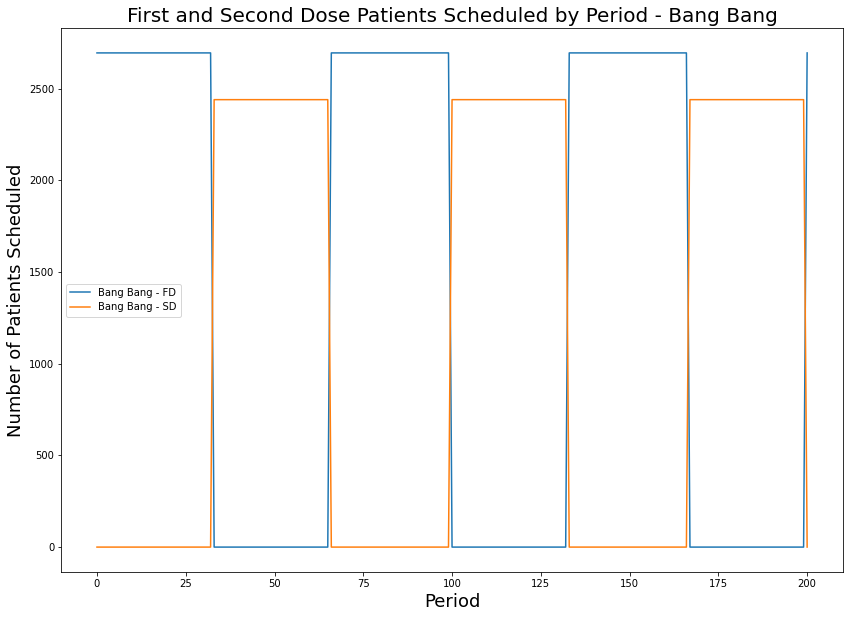

In [ ]:
plt.figure(figsize=(14,10))
plt.plot(bangbangFDQtys, label="Bang Bang - FD")
plt.plot(bangbangSDQtys, label="Bang Bang - SD")
plt.title("First and Second Dose Patients Scheduled by Period - Bang Bang", fontsize=20)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients Scheduled", fontsize=18)
plt.legend()
plt.show()

#### Capacity Check

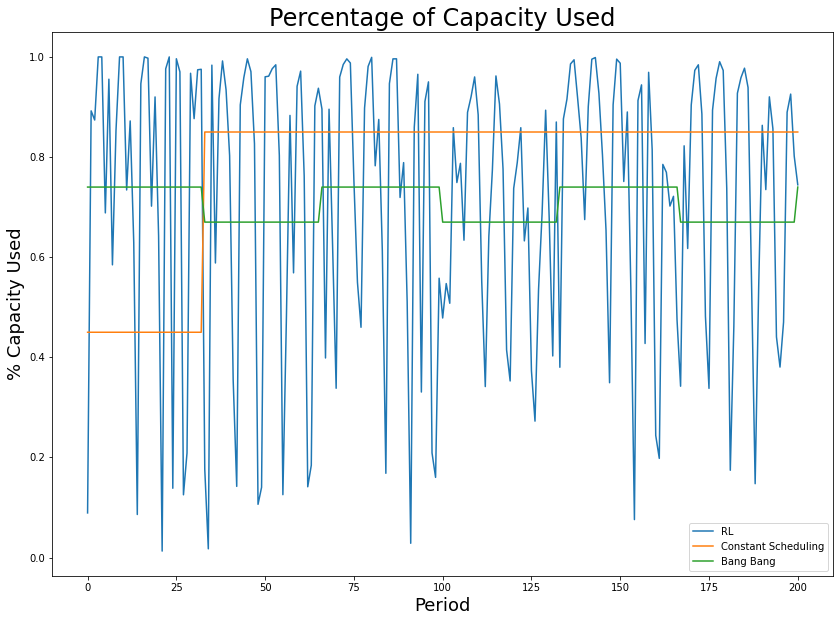

In [ ]:
# Capacity Check
plt.figure(figsize=(14,10))
plt.plot(np.add(simFDQtys, simSDQtys)/capacity, label='RL')
plt.plot(np.add(compareFDQtys, compareSDQtys)/capacity, label='Constant Scheduling')
plt.plot(np.add(bangbangFDQtys, bangbangSDQtys)/capacity, label='Bang Bang')
plt.title("Percentage of Capacity Used", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("% Capacity Used", fontsize=18)
plt.legend()
plt.show()

#### Reward

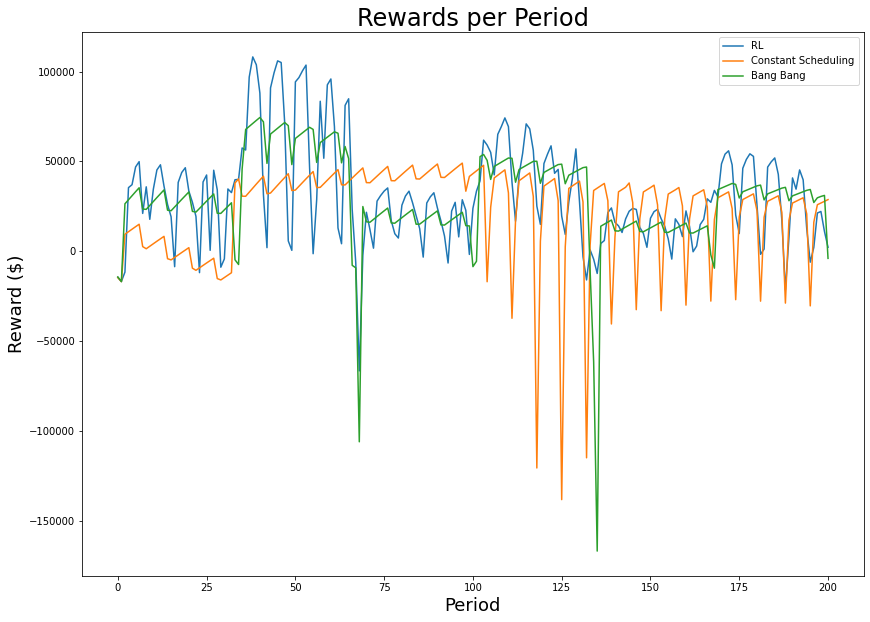

In [ ]:
# Reward
plt.figure(figsize=(14, 10))
plt.plot(simPeriodRewards, label="RL")
plt.plot(comparePeriodRewards, label="Constant Scheduling")
plt.plot(bangbangPeriodRewards, label="Bang Bang")
plt.title("Rewards per Period", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Reward ($)", fontsize=18)
plt.legend()
plt.show()

#### Cumulative Reward

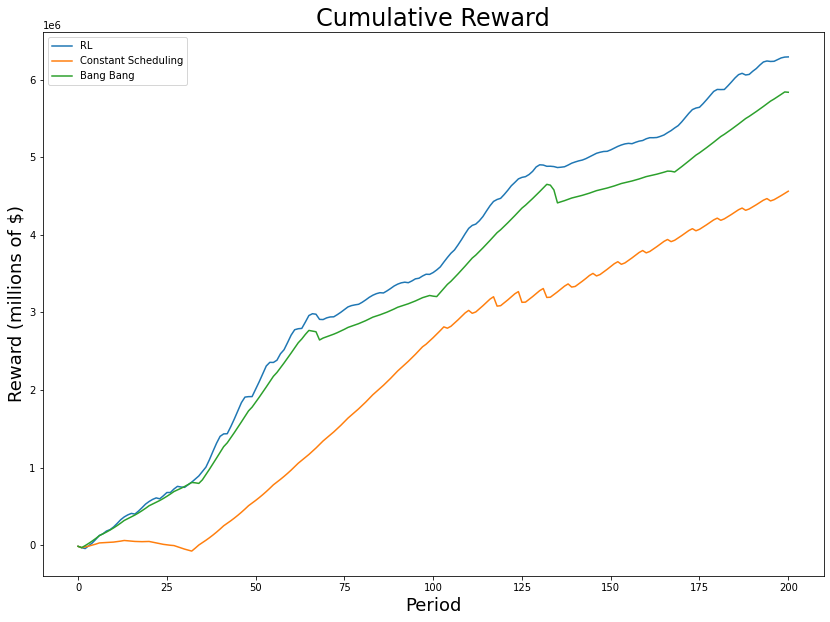

In [ ]:
# Cumulative Reward
plt.figure(figsize=(14, 10))
plt.plot(Cumulative(simPeriodRewards), label="RL")
plt.plot(Cumulative(comparePeriodRewards), label="Constant Scheduling")
plt.plot(Cumulative(bangbangPeriodRewards), label="Bang Bang")
plt.title("Cumulative Reward", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Reward (millions of $)", fontsize=18)
plt.legend()
plt.show()

#### Inventory

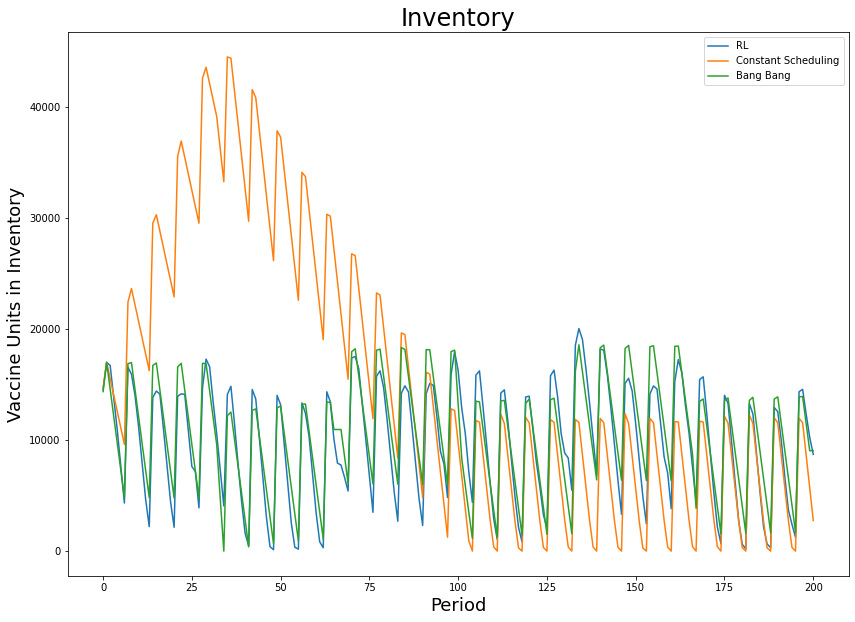

In [ ]:
# Inventory
plt.figure(figsize=(14,10))
plt.plot(simInventories, label="RL")
plt.plot(compareInventories, label="Constant Scheduling")
plt.plot(bangbangInventories, label="Bang Bang")
plt.title("Inventory", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Vaccine Units in Inventory", fontsize=18)
plt.legend()
plt.show()

##### Just the first 50 periods

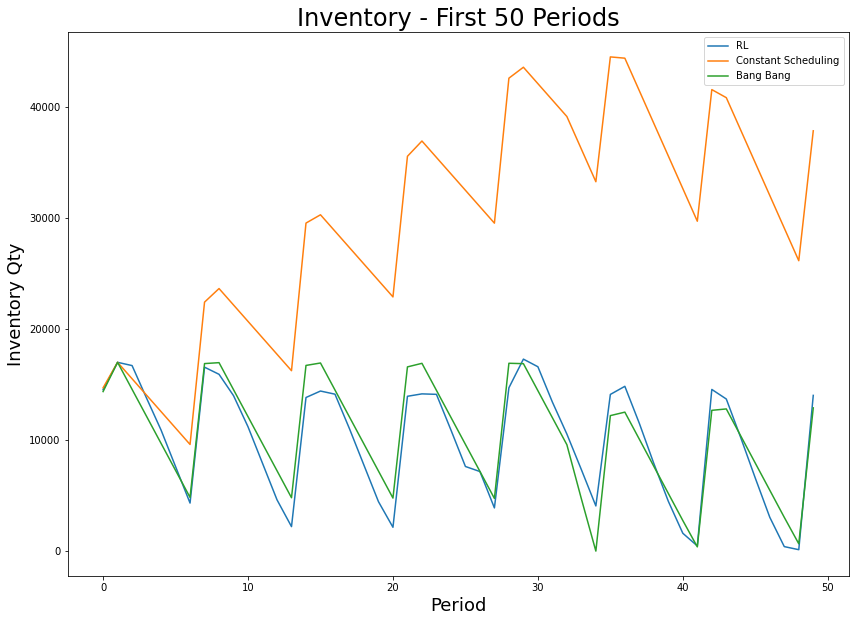

In [ ]:
# Inventory
plt.figure(figsize=(14,10))
plt.plot(simInventories[:50], label="RL")
plt.plot(compareInventories[:50], label="Constant Scheduling")
plt.plot(bangbangInventories[:50], label="Bang Bang")
plt.title("Inventory - First 50 Periods", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Inventory Qty", fontsize=18)
plt.legend()
plt.show()

#### Cumulative FD and SD Patients Scheduled

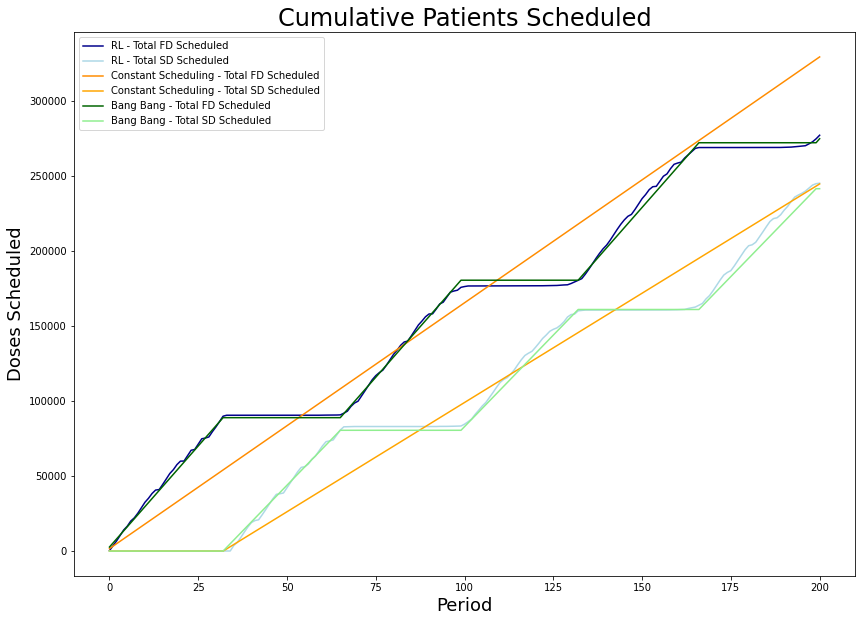

In [ ]:
# Cumulative FDs and SDs
plt.figure(figsize=(14,10))
plt.plot(Cumulative(simFDQtys), label="RL - Total FD Scheduled", color='darkblue')
plt.plot(Cumulative(simSDQtys), label="RL - Total SD Scheduled", color='lightblue')
plt.plot(Cumulative(compareFDQtys), label="Constant Scheduling - Total FD Scheduled", color='darkorange')
plt.plot(Cumulative(compareSDQtys), label="Constant Scheduling - Total SD Scheduled", color='orange')
plt.plot(Cumulative(bangbangFDQtys), label="Bang Bang - Total FD Scheduled", color='darkgreen')
plt.plot(Cumulative(bangbangSDQtys), label="Bang Bang - Total SD Scheduled", color='lightgreen')
#plt.plot(Cumulative(FDQtys)) - Cumulative(SDQtys))
plt.title("Cumulative Patients Scheduled", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Doses Scheduled", fontsize=18)
plt.legend()
plt.show()

#### Cumulative FD and SD Administered

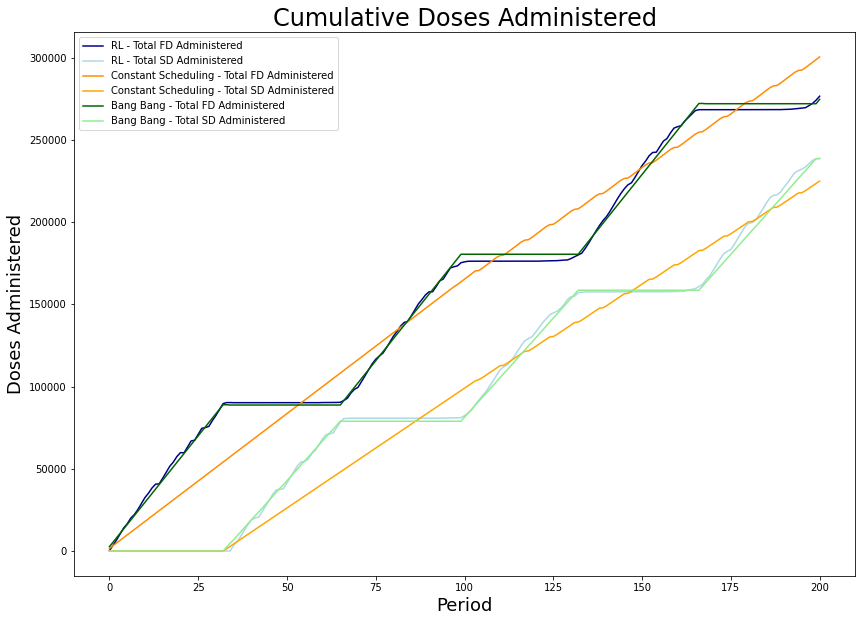

In [ ]:
# Cumulative FDs and SDs
plt.figure(figsize=(14,10))
plt.plot(np.subtract(Cumulative(simFDQtys), Cumulative(simFDStockouts)), label="RL - Total FD Administered", color='darkblue')
plt.plot(np.subtract(Cumulative(simSDQtys), Cumulative(simSDStockouts)), label="RL - Total SD Administered", color='lightblue')
plt.plot(np.subtract(Cumulative(compareFDQtys), Cumulative(compareFDStockouts)), label="Constant Scheduling - Total FD Administered", color='darkorange')
plt.plot(np.subtract(Cumulative(compareSDQtys), Cumulative(compareSDStockouts)), label="Constant Scheduling - Total SD Administered", color='orange')
plt.plot(np.subtract(Cumulative(bangbangFDQtys), Cumulative(bangbangFDStockouts)), label="Bang Bang - Total FD Administered", color='darkgreen')
plt.plot(np.subtract(Cumulative(bangbangSDQtys), Cumulative(bangbangSDStockouts)), label="Bang Bang - Total SD Administered", color='lightgreen')
plt.title("Cumulative Doses Administered", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Doses Administered", fontsize=18)
plt.legend()
plt.show()

#### Total Doses Given

In [ ]:
simAvgFDServed = Cumulative(simFDQtys)[len(simFDQtys) - 1] - Cumulative(simFDStockouts)[len(simFDStockouts) - 1]
simAvgSDServed = Cumulative(simSDQtys)[len(simSDQtys) - 1] - Cumulative(simSDStockouts)[len(simSDStockouts) - 1]

print("RL - Total First Doses Given (Average):", simAvgFDServed)
print("RL - Total Second Doses Given (Average):", simAvgSDServed)
print()

compareAvgFDServed = Cumulative(compareFDQtys)[len(compareFDQtys) - 1] - Cumulative(compareFDStockouts)[len(compareFDStockouts) - 1]
compareAvgSDServed = Cumulative(compareSDQtys)[len(compareSDQtys) - 1] - Cumulative(compareSDStockouts)[len(compareSDStockouts) - 1]

print("Constant Scheduling - Total First Doses Given (Average):", compareAvgFDServed)
print("Constant Scheduling - Total Second Doses Given (Average):", compareAvgSDServed)
print()

bangbangAvgFDServed = Cumulative(bangbangFDQtys)[len(simFDQtys) - 1] - Cumulative(bangbangFDStockouts)[len(bangbangFDStockouts) - 1]
bangbangAvgSDServed = Cumulative(bangbangSDQtys)[len(simSDQtys) - 1] - Cumulative(bangbangSDStockouts)[len(bangbangSDStockouts) - 1]

print("Bang Bang - Total First Doses Given (Average):", bangbangAvgFDServed)
print("Bang Bang - Total Second Doses Given (Average):", bangbangAvgSDServed)
print()

RL - Total First Doses Given (Average): 276528.85104404815
RL - Total Second Doses Given (Average): 238747.95544159104

Constant Scheduling - Total First Doses Given (Average): 300405.85425477265
Constant Scheduling - Total Second Doses Given (Average): 224921.46649158024

Bang Bang - Total First Doses Given (Average): 274645.6968879717
Bang Bang - Total Second Doses Given (Average): 238554.62360915449



#### Stockouts

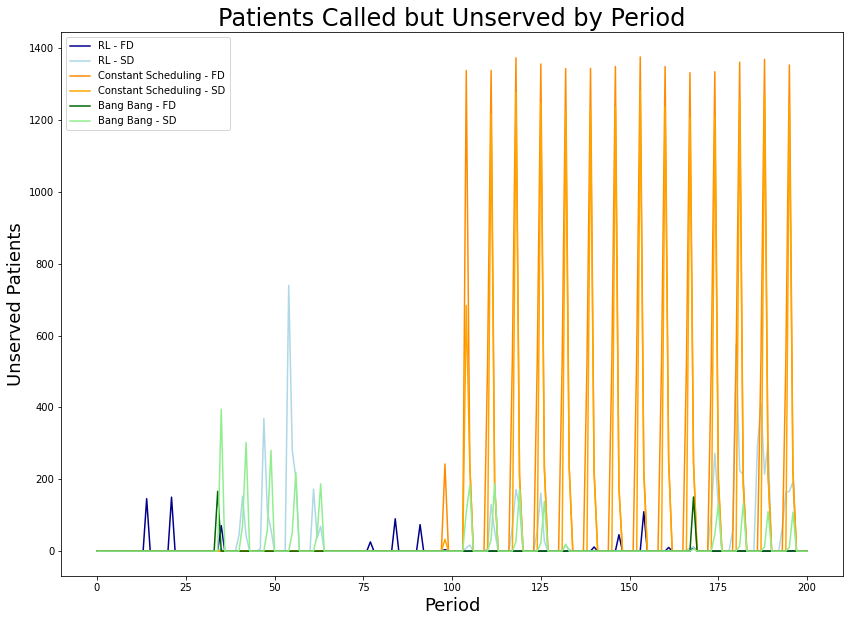

In [ ]:
# Stockouts
plt.figure(figsize=(14, 10))
plt.plot(simFDStockouts, label="RL - FD", color='darkblue')
plt.plot(simSDStockouts, label="RL - SD", color='lightblue')
plt.plot(compareFDStockouts, label="Constant Scheduling - FD", color='darkorange')
plt.plot(compareSDStockouts, label="Constant Scheduling - SD", color='orange')
plt.plot(bangbangFDStockouts, label="Bang Bang - FD", color='darkgreen')
plt.plot(bangbangSDStockouts, label="Bang Bang - SD", color='lightgreen')
plt.title("Patients Called but Unserved by Period", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Unserved Patients", fontsize=18)
plt.legend()
plt.show()

#### Cumulative Stockouts

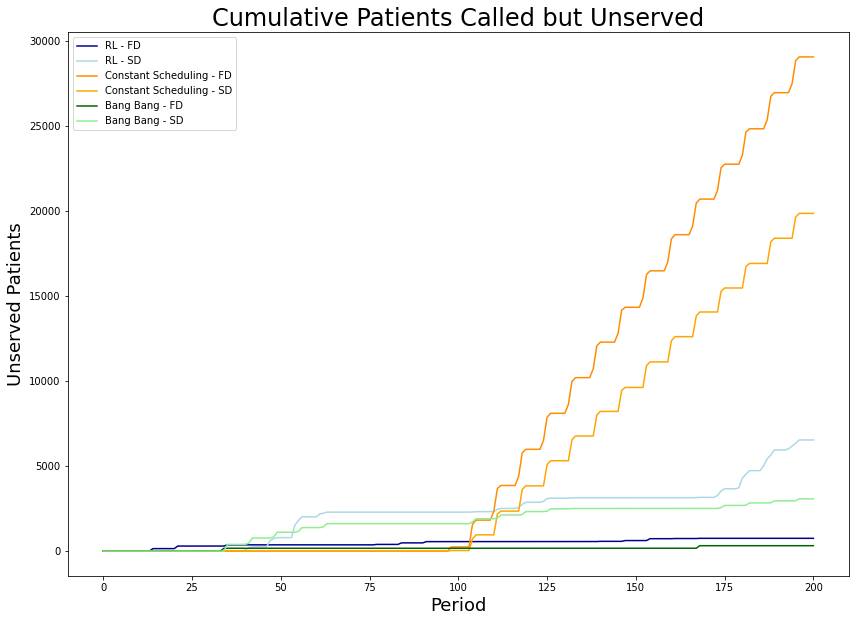

In [ ]:
# Stockouts
plt.figure(figsize=(14, 10))
plt.plot(Cumulative(simFDStockouts), label="RL - FD", color='darkblue')
plt.plot(Cumulative(simSDStockouts), label="RL - SD", color='lightblue')
plt.plot(Cumulative(compareFDStockouts), label="Constant Scheduling - FD", color='darkorange')
plt.plot(Cumulative(compareSDStockouts), label="Constant Scheduling - SD", color='orange')
plt.plot(Cumulative(bangbangFDStockouts), label="Bang Bang - FD", color='darkgreen')
plt.plot(Cumulative(bangbangSDStockouts), label="Bang Bang - SD", color='lightgreen')
plt.title("Cumulative Patients Called but Unserved", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Unserved Patients", fontsize=18)
plt.legend()
plt.show()

#### SD Patients Never Served

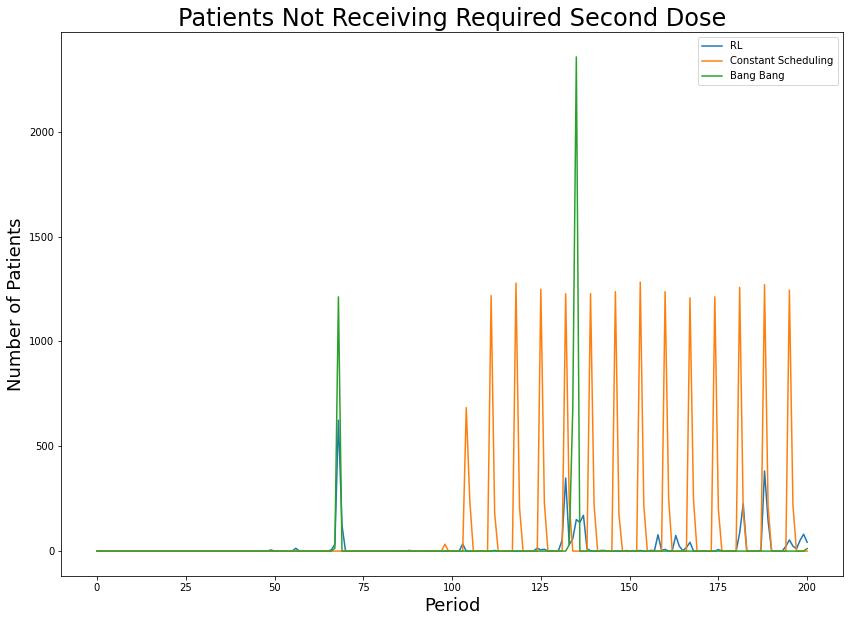

In [ ]:
# SD Patients never served
plt.figure(figsize=(14, 10))
plt.plot(simSDPatientsNeverServed, label="RL")
plt.plot(compareSDPatientsNeverServed, label="Constant Scheduling")
plt.plot(bangbangSDPatientsNeverServed, label="Bang Bang")
plt.title("Patients Not Receiving Required Second Dose", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients", fontsize=18)
plt.legend()
plt.show()

#### Cumulative SD Patients Never Served

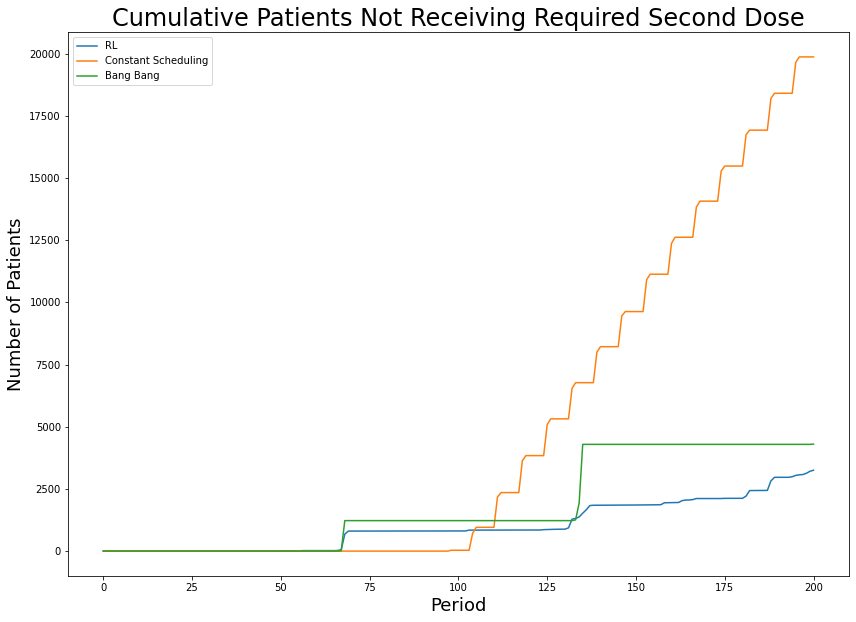

RL - Cumulative SD Patients Never Served: 3252.885889365435
RL - Percentage of total SD Patients: 0.013624769616765342

Constant Scheduling - Cumulative SD Patients Never Served: 19878.533508422854
Constant Scheduling - Percentage of total SD Patients: 0.088379885737438

Bang Bang - Cumulative SD Patients Never Served: 4304.6019813355715
Bang Bang - Percentage of total SD Patients: 0.018044512892729292



In [ ]:
# Cumulative SD Patients never served
plt.figure(figsize=(14,10))
plt.plot(Cumulative(simSDPatientsNeverServed), label="RL")
plt.plot(Cumulative(compareSDPatientsNeverServed), label="Constant Scheduling")
plt.plot(Cumulative(bangbangSDPatientsNeverServed), label="Bang Bang")
plt.title("Cumulative Patients Not Receiving Required Second Dose", fontsize=24)
plt.xlabel("Period", fontsize=18)
plt.ylabel("Number of Patients", fontsize=18)
plt.legend()
plt.show()



print("RL - Cumulative SD Patients Never Served:", Cumulative(simSDPatientsNeverServed)[len(simSDPatientsNeverServed) - 1])
print("RL - Percentage of total SD Patients:", Cumulative(simSDPatientsNeverServed)[len(simSDPatientsNeverServed) - 1] / simAvgSDServed)
print()
print("Constant Scheduling - Cumulative SD Patients Never Served:", Cumulative(compareSDPatientsNeverServed)[len(compareSDPatientsNeverServed) - 1])
print("Constant Scheduling - Percentage of total SD Patients:", Cumulative(compareSDPatientsNeverServed)[len(compareSDPatientsNeverServed) - 1] / compareAvgSDServed)
print()
print("Bang Bang - Cumulative SD Patients Never Served:", Cumulative(bangbangSDPatientsNeverServed)[len(bangbangSDPatientsNeverServed) - 1])
print("Bang Bang - Percentage of total SD Patients:", Cumulative(bangbangSDPatientsNeverServed)[len(bangbangSDPatientsNeverServed) - 1] / bangbangAvgSDServed)
print()

## Moderna Training Plot

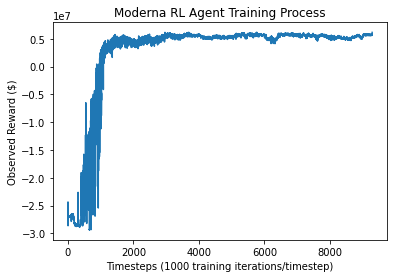

In [ ]:
modernaTrainDataFName = "drive/MyDrive/Thesis/Moderna Model 7 Training Data 4-21-2021"

modernaTrainingFile = open(modernaTrainDataFName, "rb")
modernaTrainingData = pickle.load(modernaTrainingFile)
modernaTrainingFile.close()


plt.plot(modernaTrainingData)
plt.title("Moderna RL Agent Training Process")
plt.xlabel("Timesteps (1000 training iterations/timestep)")
plt.ylabel("Observed Reward ($)")
plt.show()